In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, pickle, seaborn as sns, sympy, matplotlib as mpl
from astropy.io import fits, ascii as ascii_io, votable
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
import astropy.coordinates as coord

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.xmatch import XMatch
from astropy.table import Table
from gdpyc import GasMap, DustMap

from mpl_toolkits import mplot3d
from scipy import stats, optimize
from astroquery.simbad import Simbad
from astropy.table import Table, vstack
import math
from collections import Counter
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')

In [2]:
BeSS = ascii_io.read("./catalogs/BeSS_catalog.csv", format="csv", header_start=0, data_start=1)
BeSS['_RAJ2000']= Angle(BeSS['RA'], 'hourangle').degree*u.degree # BeSS["_RAJ2000"] = [hms_to_dec(hms) for hms in BeSS["RA"]]*u.degree
BeSS['_DEJ2000'] = Angle(BeSS['DEC'], 'deg').degree*u.degree #BeSS["_DEJ2000"] = [dms_to_dec(dms) for dms in BeSS["DEC"]]*u.degree
BeSS.pprint()

 #    Be star    Category ...       _RAJ2000            _DEJ2000     
                          ...         deg                 deg        
---- ---------- --------- ... ------------------- -------------------
   1 BD+62 2346 Classical ... 0.35291666666666666   63.50436944444444
   2  HD 224905 Classical ... 0.41095833333333326   60.44992222222222
   3  HD 225095 Classical ...  0.8631249999999999   55.55089722222222
   4      2 Cet Classical ...  0.9349583333333332 -17.335991666666665
   5     10 Cas Classical ...  1.6105833333333333   64.19616944444445
   6 BD+59 2829 Classical ...  1.7012499999999997  60.600230555555555
   7    BD+62 1 Classical ...            1.888125   63.08032777777778
   8   BD+62 11 Classical ...  2.6954999999999996  63.172936111111106
   9   V742 Cas Classical ...   2.904791666666666   58.21182777777778
  10   EM* AS 2 Classical ...  3.2468749999999997   66.32206388888889
 ...        ...       ... ...                 ...                 ...
2255   V817 Cas Clas

df_BeSS = pd.read_csv("/Users/yanghui/Desktop/Research/2020/Proposal/XMM/BeSS_Epsilon/BeSS_catalog.csv")
#BeSS['_RAJ2000']= Angle(BeSS['ra'], 'hourangle').degree*u.degree # BeSS["_RAJ2000"] = [hms_to_dec(hms) for hms in BeSS["RA"]]*u.degree
#BeSS['_DEJ2000'] = Angle(BeSS['dec'], 'deg').degree*u.degree #BeSS["_DEJ2000"] = [dms_to_dec(dms) for dms in BeSS["DEC"]]*u.degree
#BeSS.pprint()
#print(df_BeSS)
Simbad.add_votable_fields('typed_id')
simbad_result = Simbad.query_objects(df_BeSS.name).to_pandas()
#df_comb = pd.concat([df_BeSS, simbad_result], axis=1)['name']

#print(df_comb.columns)
#BeSS['_RAJ2000']= Angle(df_comb['RA'], 'hourangle').degree*u.degree # BeSS["_RAJ2000"] = [hms_to_dec(hms) for hms in BeSS["RA"]]*u.degree
#BeSS['_DEJ2000'] = Angle(df_comb['DEC'], 'deg').degree*u.degree #BeSS["_DEJ2000"] = [dms_to_dec(dms) for dms in BeSS["DEC"]]*u.degree

df_comb = pd.concat([df_BeSS, simbad_result], axis=1)[['name', 'type','ra','dec', 'MAIN_ID', 'RA', 'DEC']]

df_comb['_RAJ2000'],  df_comb['_DEJ2000'] = df_comb['RA'],  df_comb['DEC']
#print(df_comb.loc[df_comb['_RAJ2000']== "",:] )
df_comb.loc[df_comb['_RAJ2000']== "", '_RAJ2000'] = df_comb.loc[df_comb['_RAJ2000']== "", 'ra'] 
df_comb.loc[df_comb['_DEJ2000']== "", '_DEJ2000'] = df_comb.loc[df_comb['_DEJ2000']== "", 'dec'] 

df_comb['_RAJ2000']= df_comb.apply(lambda row: Angle(row._RAJ2000, unit='hourangle').degree, axis=1) #Angle(df_comb['_RAJ2000'], unit='hourangle')*u.degree# 
df_comb['_DEJ2000']= df_comb.apply(lambda row: Angle(row._DEJ2000, unit='deg').degree, axis=1)

radec = [[df_comb.loc[j,'_RAJ2000'], df_comb.loc[j, '_DEJ2000']] for j in range(len(df_comb))]
BeSS = Table(Angle(radec, 'deg'), names=('_RAJ2000', '_DEJ2000'))

In [3]:
def find_nearest(df, ind_col='_q', sep_col='_r', check=False, drop=False):
    '''
    drop multiple matches for the source with the same ind_col column by keeping the nearest match of sep_col column
    '''
    
    print('Before cleaning dup, ', len(df), 'rows.')
    df_nearest = pd.DataFrame(columns=[ind_col])
    for i in df[ind_col].unique():
        df_sub = df.loc[df[ind_col]==i]
        instances = len(df_sub)
        if instances == 0:
            pass
        elif drop and i in drop:
            pass
        else:
            if check and instances>1:
                print(df_sub)
                
            df_src = df_sub.loc[df_sub[sep_col] ==min(df_sub[sep_col])]
            if len(df_src)>1:
                #pass
                #print(df_src.head(1))
                df_nearest = pd.concat([df_nearest, df_src.head(1)])
            else:
                df_nearest = pd.concat([df_nearest, df_src])
    print('After cleaning dup, ', len(df_nearest), 'rows.')
    return df_nearest

In [4]:
v = Vizier(columns=['all', 'EDR3Name','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

Gaia_BeSS_1as = v.query_region(BeSS, catalog="I/350/gaiaedr3", radius="1s")
Gaia_matched = Gaia_BeSS_1as[0]["_q","_r","_RAJ2000","_DEJ2000","EDR3Name","Source","Plx","pmRA","pmDE","epsi","sepsi","RUWE","Gmag","BPmag","RPmag","Tefftemp"]

gaia_df = Gaia_matched.to_pandas()
print(len(gaia_df))
gaia_df = gaia_df.dropna(subset=['_r'])
print(len(gaia_df))
gaia_df['Source'] = gaia_df.apply(lambda row: np.int64(row.EDR3Name[10:]), axis=1)
gaia_df = find_nearest(gaia_df, ind_col='Source', sep_col='_r', check=False, drop=False)
#gaia_df = gaia_df.drop_duplicates(subset=['Source'])
print(len(gaia_df))
#df_gaia = find_nearest(gaia_df, ind_col='_q', sep_col='_r', check=True, drop=[])

2116
2115
Before cleaning dup,  2115 rows.
After cleaning dup,  2113 rows.
2113


In [5]:
gaia_df

,Source,_q,_r,_RAJ2000,_DEJ2000,EDR3Name,Plx,pmRA,pmDE,epsi,sepsi,RUWE,Gmag,BPmag,RPmag,Tefftemp
0,431593257757382912,1.0,0.081,0.352894,63.504365,Gaia EDR3 431593257757382912,0.8427,0.904,-3.903,0.477,314.000000,3.759,9.334448,9.622060,8.840662,NaN
1,429341153012514176,2.0,0.024,0.410978,60.449924,Gaia EDR3 429341153012514176,0.7747,-3.198,-1.531,0.124,14.400000,0.868,8.410068,8.476914,8.234395,NaN
2,420875841188703360,3.0,0.058,0.863112,55.550898,Gaia EDR3 420875841188703360,0.7951,-1.752,-1.475,0.307,76.800003,1.041,7.900065,7.871469,7.892114,NaN
3,2414783622022208128,4.0,0.401,0.934949,-17.335991,Gaia EDR3 2414783622022208128,10.5075,25.363,-8.987,0.790,880.000000,0.814,4.516587,4.507541,4.523403,NaN
4,431696822314371456,5.0,0.133,1.610572,64.196158,Gaia EDR3 431696822314371456,3.4070,9.248,0.828,0.472,315.000000,0.950,5.538360,5.534208,5.504747,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111,2209768924430155264,2260.0,0.035,359.392077,66.431630,Gaia EDR3 2209768924430155264,1.4468,-1.631,-1.976,1.905,3790.000000,16.186,10.277722,10.439728,9.358917,NaN
2112,1926411961766632960,2261.0,0.238,359.693497,46.413179,Gaia EDR3 1926411961766632960,2.5713,15.266,0.490,0.317,121.000000,0.951,6.486610,6.455729,6.479377,NaN
2113,2873823129549261056,2262.0,0.056,359.705149,32.381707,Gaia EDR3 2873823129549261056,1.8755,1.694,-3.388,0.319,116.000000,0.924,6.524699,6.472485,6.580116,NaN
2114,1999574461912020736,2263.0,0.033,359.812393,60.022482,Gaia EDR3 1999574461912020736,0.3009,-3.281,-1.946,0.126,22.400000,1.155,9.367801,9.633059,8.913928,NaN


Text(0, 0.5, 'BPmag')

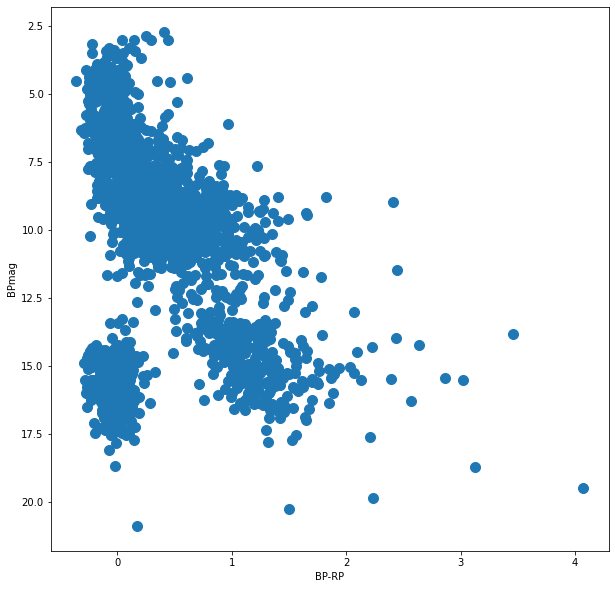

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(gaia_df['BPmag']-gaia_df['RPmag'], gaia_df['BPmag'], s=100)
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('BPmag')

In [7]:
# matching to gaiaedr3dist to get the distance info.

v = Vizier(columns=['all','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

Gaiadist_BeSS_1as = v.query_region(BeSS, catalog="I/352/gedr3dis", radius="1s")
#print(Gaiadist_BeSS_1as[0].columns)
Gaiadist_matched = Gaiadist_BeSS_1as[0]["_q","_r","Source","rgeo","b_rgeo","B_rgeo","rpgeo","b_rpgeo","B_rpgeo","Flag"]

gaiadist_df = Gaiadist_matched.to_pandas()
print(len(gaiadist_df))
#gaiadist_df = gaiadist_df.drop_duplicates(subset=['Source'])
gaiadist_df = find_nearest(gaiadist_df, ind_col='Source', sep_col='_r', check=False, drop=False)
print(len(gaiadist_df))
#df_gaiadist = find_nearest(gaiadist_df, ind_col='_q', sep_col='_r')

2060
Before cleaning dup,  2060 rows.
After cleaning dup,  2059 rows.
2059


In [8]:
df_gaia_comb = pd.merge(gaia_df, gaiadist_df, on='Source', how="outer")

#df_gaia_comb['Source_2'] = df_gaia_comb.apply(lambda row: np.int64(row.EDR3Name[10:]), axis=1)

#print(df_gaia_comb[df_gaia_comb['Source_2'] == df_gaia_comb['Source']])
#print(df_gaia_comb)

In [9]:
df_gaia_comb['_q'] = df_gaia_comb['_q_x']

#print(df_gaia_comb.loc[df_gaia_comb['_q'].isnull(), ['_q_y','Source']])

df_gaia_comb['BP-RP'] = df_gaia_comb['BPmag']-df_gaia_comb['RPmag']

df_gaia_comb['abs_BPmag'] = df_gaia_comb['BPmag']-5*(np.log10(df_gaia_comb['rgeo'])-1)

absmag = lambda df, col : df[col]-5*(np.log10(df['rgeo'])-1)

In [10]:
print(len(df_gaia_comb))

# dropping those multiple matches with larger separations and no magnitude and distance measurements

for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    #if instances>2:
        #print(df_sub)
    if instances >= 2:
        #if df_src = df_sub.loc[df_sub['_r'] ==max(df_sub['_r'])]
        sep_min = min(df_sub['_r_x'])
        #print(df_sub)
        drop_idx = df_gaia_comb[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r_x'] !=sep_min) & (df_gaia_comb['abs_BPmag'].isnull()) ].index
        #print(df_gaia_comb.loc[drop_idx])
        df_gaia_comb.drop(drop_idx, inplace = True)
        #df_gaia_comb.drop(df_gaia_comb[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r_x'] ==sep_max) ].index, inplace = True)
    
print(len(df_gaia_comb))        


2113
2086


In [11]:
# Simbad coordinates 
'''
for q, src in zip([13,229, 332, 671, 739, 811, 813, 835, 858, 859, 889, 2117], 
                  [431147444454518400, 4689013541697570688, 509978579873632384, 462144871963953792, 205807067523449984,4660172733210657664,
                  4660179708211442048, 4660181769796320000, 4660250867252215424, 3017342485415388160, 4657686359440941568,
                  1870779903225039872]):
    
    df_gaia_comb.drop(df_gaia_comb[(df_gaia_comb['_q'] == q) & (df_gaia_comb['Source'] != src) ].index, inplace = True)
'''

"\nfor q, src in zip([13,229, 332, 671, 739, 811, 813, 835, 858, 859, 889, 2117], \n                  [431147444454518400, 4689013541697570688, 509978579873632384, 462144871963953792, 205807067523449984,4660172733210657664,\n                  4660179708211442048, 4660181769796320000, 4660250867252215424, 3017342485415388160, 4657686359440941568,\n                  1870779903225039872]):\n    \n    df_gaia_comb.drop(df_gaia_comb[(df_gaia_comb['_q'] == q) & (df_gaia_comb['Source'] != src) ].index, inplace = True)\n"

1       _q   _r_x              Source  _RAJ2000   _DEJ2000     BP-RP  abs_BPmag
12  13.0  0.287  431147444447013760  6.667260  64.432133  1.243053  -3.712971
13  13.0  0.271  431147444454518400  6.667083  64.431995  1.251686  -0.744201
2         _q   _r_x              Source   _RAJ2000  _DEJ2000     BP-RP  \
295  332.0  0.598  509978579873632384  23.906890  61.28051  0.489611   
296  332.0  0.789  509978579881384832  23.907223  61.28016  0.490342   

     abs_BPmag  
295  -0.373399  
296  -1.479086  
3         _q   _r_x              Source   _RAJ2000   _DEJ2000     BP-RP  \
627  671.0  0.013  462144871963953792  48.819787  59.913653  0.765817   
628  671.0  0.715  462144876256342784  48.819896  59.913467  0.777010   

     abs_BPmag  
627  -1.499328  
628  -4.354442  
4         _q   _r_x              Source   _RAJ2000   _DEJ2000     BP-RP  \
687  739.0  0.064  205807067523449984  76.183984  44.958616  0.534231   
688  739.0  0.689  205807071819222784  76.184067  44.958442  0.540419   


Text(0, 0.5, 'Absolute BPmag')

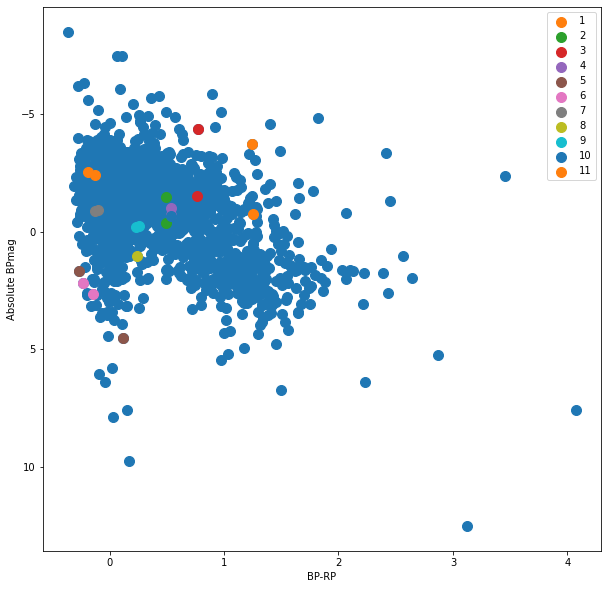

In [12]:
# those are the confused gaia counterparts to BeSS stars

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(df_gaia_comb['BP-RP'], df_gaia_comb['abs_BPmag'], s=100)

j=1
for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances == 1:
        pass
    else:
        if instances == 0:
            print('strange')
        else:
            ax.scatter(df_sub['BP-RP'], df_sub['abs_BPmag'], s=100, label=j)
            print(j, df_sub[['_q','_r_x','Source','_RAJ2000','_DEJ2000','BP-RP','abs_BPmag']])
            j += 1

        
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('Absolute BPmag')

In [15]:
# we can just take the closest counterparts 

df_gaia = find_nearest(df_gaia_comb, ind_col='_q', sep_col='_r_x', drop=[])

print(df_gaia.loc[df_gaia['EDR3Name'] == 'Gaia EDR3 4685927315640017792'])


Before cleaning dup,  2086 rows.
After cleaning dup,  2075 rows.
      _q               Source  _q_x   _r_x   _RAJ2000  _DEJ2000  \
44  52.0  4685927315640017792  52.0  0.086  12.425033 -73.38741   

                         EDR3Name     Plx  pmRA   pmDE  ...   _r_y  \
44  Gaia EDR3 4685927315640017792 -0.0301  0.53 -1.209  ...  0.086   

          rgeo      b_rgeo      B_rgeo       rpgeo     b_rpgeo     B_rpgeo  \
44  22524.3223  17164.3086  28180.7051  27205.6895  18131.4688  34078.1172   

       Flag     BP-RP  abs_BPmag  
44  10122.0  0.185655  -1.922681  

[1 rows x 28 columns]


In [16]:
df_BeSS = BeSS.to_pandas()
print(df_BeSS)

# df_BeSS['sep_IGR'] = df_BeSS.apply(lambda row: SkyCoord(row._RAJ2000*u.deg, row._DEJ2000*u.deg, frame='icrs').separation(SkyCoord(((11+(44.+0.29/60)/60)*15)*u.deg, (-1)*(61+(7+36.482/60)/60)*u.deg, frame='icrs')).arcsec, axis=1)

# print(((11+(44.+0.29/60)/60)*15),(-1)*(61+(7+36.482/60)/60))
# print(df_BeSS[df_BeSS['sep_IGR']==min(df_BeSS['sep_IGR'])])

         #     Be star   Category           RA           DEC       V  \
0        1  BD+62 2346  Classical  00 01 24.70   63 30 15.73   9.730   
1        2   HD 224905  Classical  00 01 38.63   60 26 59.72   8.470   
2        3   HD 225095  Classical  00 03 27.15   55 33 03.23   7.950   
3        4       2 Cet  Classical  00 03 44.39  -17 20 09.57   4.543   
4        5      10 Cas  Classical  00 06 26.54   64 11 46.21   5.567   
...    ...         ...        ...          ...           ...     ...   
2259  2260  BD+65 1970  Classical  23 57 34.10   66 25 53.84  10.170   
2260  2261      LQ And  Classical  23 58 46.44   46 24 47.44   6.542   
2261  2262   HD 224544  Classical  23 58 49.24   32 22 54.14   6.524   
2262  2263   HD 224599  Classical  23 59 14.97   60 01 20.93   9.700   
2263  2264     eps Tuc  Classical  23 59 54.98  -65 34 37.68   4.490   

           Type  vsini  Nb of spectra in BeSS    _RAJ2000   _DEJ2000  
0          B0Ve   <NA>                      3    0.352917  63.50

"\ndf_BeSS['sep_IGR'] = df_BeSS.apply(lambda row: SkyCoord(row._RAJ2000*u.deg, row._DEJ2000*u.deg, frame='icrs').separation(SkyCoord(((11+(44.+0.29/60)/60)*15)*u.deg, (-1)*(61+(7+36.482/60)/60)*u.deg, frame='icrs')).arcsec, axis=1)\n\nprint(((11+(44.+0.29/60)/60)*15),(-1)*(61+(7+36.482/60)/60))\nprint(df_BeSS[df_BeSS['sep_IGR']==min(df_BeSS['sep_IGR'])])\n"

In [19]:
df_comb = pd.merge(df_BeSS[['#','Be star','_RAJ2000', '_DEJ2000','V','Type']], df_gaia.drop(columns=['_q_x','_r_x','_q_y', '_r_y']), left_on="#", right_on="_q", how="outer")
print(df_comb.columns)

Index(['#', 'Be star', '_RAJ2000_x', '_DEJ2000_x', 'V', 'Type', '_q', 'Source',
       '_RAJ2000_y', '_DEJ2000_y', 'EDR3Name', 'Plx', 'pmRA', 'pmDE', 'epsi',
       'sepsi', 'RUWE', 'Gmag', 'BPmag', 'RPmag', 'Tefftemp', 'rgeo', 'b_rgeo',
       'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'Flag', 'BP-RP', 'abs_BPmag'],
      dtype='object')


In [20]:
df_comb['_RAJ2000'], df_comb['_DEJ2000'] = df_comb['_RAJ2000_y'], df_comb['_DEJ2000_y']
df_comb.loc[df_comb['_RAJ2000'].isnull(), '_RAJ2000'] = df_comb.loc[df_comb['_RAJ2000'].isnull(), '_RAJ2000_x']
df_comb.loc[df_comb['_DEJ2000'].isnull(), '_DEJ2000'] = df_comb.loc[df_comb['_DEJ2000'].isnull(), '_DEJ2000_x']

In [22]:
cat_ids = ["IX/57/csc2master","IX/59/xmm4dr9s","IX/58/2sxpscle"]
Xmatch = [None, None, None]
radii = ["2s","5s","9s"]
for i in range(len(cat_ids)):
    Xmatch[i] = v.query_region(BeSS, catalog=cat_ids[i], radius=radii[i])
    print("Successfully matched BeSS with",cat_ids[i])
[CSC_xmatch, XMM_xmatch, XRT_xmatch] = Xmatch

Successfully matched BeSS with IX/57/csc2master
Successfully matched BeSS with IX/59/xmm4dr9s
Successfully matched BeSS with IX/58/2sxpscle


In [23]:
CSC_xmatch[0]

_q,_RAJ2000,_DEJ2000,_r,recno,_2CXO,RAICRS,DEICRS,r0,r1,PA,GLON,GLAT,fe,fc,fp,fv,fst,fs,fa,fi,fr,fm,ff,fVi,majb,majh,majm,majs,maju,majw,b_majb,b_majh,b_majm,b_majs,b_maju,b_majw,B_majb,B_majh,B_majm,B_majs,B_maju,B_majw,minb,minh,minm,mins,minu,minw,b_minb,b_minh,b_minm,b_mins,b_minu,b_minw,B_minb,B_minh,B_minm,B_mins,B_minu,B_minw,Areab,Areah,Aream,Areas,Areau,Areaw,Ns,PFluxb,PFluxh,PFluxm,PFluxs,PFluxu,PFluxw,b_PFluxb,b_PFluxh,b_PFluxm,b_PFluxs,b_PFluxu,b_PFluxw,B_PFluxb,B_PFluxh,B_PFluxm,B_PFluxs,B_PFluxu,B_PFluxw,PF90b,PF90h,PF90m,PF90s,PF90u,PF90w,b_PF90b,b_PF90h,b_PF90m,b_PF90s,b_PF90u,b_PF90w,B_PF90b,B_PF90h,B_PF90m,B_PF90s,B_PF90u,B_PF90w,Fluxb,Fluxh,Fluxm,Fluxs,Fluxu,Fluxw,b_Fluxb,b_Fluxh,b_Fluxm,b_Fluxs,b_Fluxu,b_Fluxw,B_Fluxb,B_Fluxh,B_Fluxm,B_Fluxs,B_Fluxu,B_Fluxw,F90b,F90h,F90m,F90s,F90u,F90w,b_F90b,b_F90h,b_F90m,b_F90s,b_F90u,b_F90w,B_F90b,B_F90h,B_F90m,B_F90s,B_F90u,B_F90w,PFavgb,PFavgh,PFavgm,PFavgs,PFavgu,PFavgw,b_PFavgb,b_PFavgh,b_PFavgm,b_PFavgs,b_PFavgu,b_PFavgw,B_PFavgb,B_PFavgh,B_PFavgm,B_PFavgs,B_PFavgu,B_PFavgw,PF90avgb,PF90avgh,PF90avgm,PF90avgs,PF90avgu,PF90avgw,b_PF90avgb,b_PF90avgh,b_PF90avgm,b_PF90avgs,b_PF90avgu,b_PF90avgw,B_PF90avgb,B_PF90avgh,B_PF90avgm,B_PF90avgs,B_PF90avgu,B_PF90avgw,Favgb,Favgh,Favgm,Favgs,Favgu,Favgw,b_Favgb,b_Favgh,b_Favgm,b_Favgs,b_Favgu,b_Favgw,B_Favgb,B_Favgh,B_Favgm,B_Favgs,B_Favgu,B_Favgw,F90avgb,F90avgh,F90avgm,F90avgs,F90avgu,F90avgw,b_F90avgb,b_F90avgh,b_F90avgm,b_F90avgs,b_F90avgu,b_F90avgw,B_F90avgb,B_F90avgh,B_F90avgm,B_F90avgs,B_F90avgu,B_F90avgw,FPLb,FPLh,FPLm,FPLs,FPLu,FPLw,b_FPLb,b_FPLh,b_FPLm,b_FPLs,b_FPLu,b_FPLw,B_FPLb,B_FPLh,B_FPLm,B_FPLs,B_FPLu,B_FPLw,FPL90b,FPL90h,FPL90m,FPL90s,FPL90u,FPL90w,b_FPL90b,b_FPL90h,b_FPL90m,b_FPL90s,b_FPL90u,b_FPL90w,B_FPL90b,B_FPL90h,B_FPL90m,B_FPL90s,B_FPL90u,B_FPL90w,FBBb,FBBh,FBBm,FBBs,FBBu,FBBw,b_FBBb,b_FBBh,b_FBBm,b_FBBs,b_FBBu,b_FBBw,B_FBBb,B_FBBh,B_FBBm,B_FBBs,B_FBBu,B_FBBw,FBB90b,FBB90h,FBB90m,FBB90s,FBB90u,FBB90w,b_FBB90b,b_FBB90h,b_FBB90m,b_FBB90s,b_FBB90u,b_FBB90w,B_FBB90b,B_FBB90h,B_FBB90m,B_FBB90s,B_FBB90u,B_FBB90w,FBSb,FBSh,FBSm,FBSs,FBSu,FBSw,b_FBSb,b_FBSh,b_FBSm,b_FBSs,b_FBSu,b_FBSw,B_FBSb,B_FBSh,B_FBSm,B_FBSs,B_FBSu,B_FBSw,FBS90b,FBS90h,FBS90m,FBS90s,FBS90u,FBS90w,b_FBS90b,b_FBS90h,b_FBS90m,b_FBS90s,b_FBS90u,b_FBS90w,B_FBS90b,B_FBS90h,B_FBS90m,B_FBS90s,B_FBS90u,B_FBS90w,FAPb,FAPh,FAPm,FAPs,FAPu,FAPw,b_FAPb,b_FAPh,b_FAPm,b_FAPs,b_FAPu,b_FAPw,B_FAPb,B_FAPh,B_FAPm,B_FAPs,B_FAPu,B_FAPw,FAP90b,FAP90h,FAP90m,FAP90s,FAP90u,FAP90w,b_FAP90b,b_FAP90h,b_FAP90m,b_FAP90s,b_FAP90u,b_FAP90w,B_FAP90b,B_FAP90h,B_FAP90m,B_FAP90s,B_FAP90u,B_FAP90w,Ldet,LClass,S_N,FPL0.5-7,b_FPL0.5-7,B_FPL0.5-7,GamPL,b_GamPL,B_GamPL,NHPL,b_NHPL,B_NHPL,AmpPL,b_AmpPL,B_AmpPL,Chi2PL,FBB0.5-7,b_FBB0.5-7,B_FBB0.5-7,kTBB,b_kTBB,B_kTBB,NHBB,b_NHBB,B_NHBB,AmpBB,b_AmpBB,B_AmpBB,Chi2BB,FBS0.5-7,b_FBS0.5-7,B_FBS0.5-7,kTBS,b_kTBS,B_kTBS,NHBS,b_NHBS,B_NHBS,AmpBS,b_AmpBS,B_AmpBS,Chi2BS,NHGal,HRhm,b_HRhm,B_HRhm,ViPhm,ViShm,HRhs,b_HRhs,B_HRhs,ViPhs,ViShs,HRms,b_HRms,B_HRms,ViPms,ViSms,VaKSb,VaKSh,VaKSm,VaKSs,VaKSu,VaKSw,VaKPb,VaKPh,VaKPm,VaKPs,VaKPu,VaKPw,VaGLb,VaGLh,VaGLm,VaGLs,VaGLu,VaGLw,VaGLIb,VaGLIh,VaGLIm,VaGLIs,VaGLIu,VaGLIw,Vib,Vih,Vim,Vis,Viu,Viw,ViIb,ViIh,ViIm,ViIs,ViIu,ViIw,ViSb,ViSh,ViSm,ViSs,ViSu,ViSw,fdw,Nac,ExpAC,Nhrc,ExpHRC
,deg,deg,arcsec,,,deg,deg,arcsec,arcsec,deg,deg,deg,,,,,,,,,,,,,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec2,arcsec2,arcsec2,arcsec2,arcsec2,arcsec2,,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph / s,cm2 ph

In [24]:
Chandra_sources = CSC_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","_2CXO",'Fluxb', 'Fluxh', 'Fluxm',
       'Fluxs', 'Fluxu', 'Fluxw', 'HRhm', 'HRhs', 'HRms', 'GamPL', 'NHPL'].to_pandas()
chandra_bands = {"b":(0.5,7), "h":(2,7), "m":(1.2,2), "s":(0.5,1.2), "u":(0.2,0.5)}

XMM_sources = XMM_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","_4XMM",'Flux1', 'e_Flux1',
       'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5',
       'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1', 'e_HR1',
       'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4'].to_pandas()
xmm_bands = dict(zip(list("1234589"),[(0.2,0.5),(0.5,1.0),(1.0,2.0),(2.0,4.5),(4.5,12.0),(0.2,12.0),(0.5,4.5)]))

XRT_sources = XRT_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000",'_2SXPS', 'CR0', 'E_CR0', 'e_CR0', 'HR1', 'HR2', 'CR1',
       'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0',
       'FPO0', 'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1'].to_pandas()

In [25]:
# these are the one with multiple matches from X-ray catalogs
for df in [Chandra_sources, XMM_sources, XRT_sources]:

    print(df[df.duplicated(subset=['_q'], keep=False)])
    print(max(df['_r']),"\n")

      _q     _r    _RAJ2000   _DEJ2000              _2CXO         Fluxb  \
26   892  0.886   84.727452  26.315550  J053854.5+261855X           NaN   
27   892  0.259   84.727417  26.315725   J053854.5+261856  3.145458e-12   
37  1456  0.235  172.778935 -62.946932   J113106.9-625648  2.660139e-12   
38  1456  0.847  172.779145 -62.946756  J113106.9-625648X           NaN   

           Fluxh         Fluxm         Fluxs         Fluxu  Fluxw     HRhm  \
26           NaN           NaN           NaN           NaN    NaN      NaN   
27  2.900373e-12  2.314897e-13  6.522526e-14  6.920638e-14    NaN  0.58339   
37  2.563811e-12  1.385348e-13  1.292182e-14  0.000000e+00    NaN  0.67208   
38           NaN           NaN           NaN           NaN    NaN      NaN   

       HRhs     HRms     GamPL     NHPL  
26      NaN      NaN       NaN      NaN  
27  0.77327  0.34603  0.561029  32.6370  
37  0.93067  0.68582  0.065576  48.8438  
38      NaN      NaN       NaN      NaN  
1.873 

Empty DataFrame

In [26]:
# take the closest counterpart
df_CSC = find_nearest(Chandra_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)
df_XMM = find_nearest(XMM_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)
df_XRT = find_nearest(XRT_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)

Before cleaning dup,  68 rows.
After cleaning dup,  66 rows.
Before cleaning dup,  99 rows.
After cleaning dup,  99 rows.
Before cleaning dup,  61 rows.
After cleaning dup,  61 rows.


In [70]:
# checking back with X-ray sources' optical counterparts

v = Vizier(columns=['all', 'EDR3Name','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

X_gaia = [None, None, None]
for i, df, radius in zip(range(3), [df_CSC, df_XMM, df_XRT], ["2s", "5s", '9s']):
    #print(i, radius, len(df))
    #print(df[24:30])
    #print(df.iloc[26, ['_RAJ2000', '_DEJ2000']])
    #[print(j, [df.loc[j,'_RAJ2000'], df.loc[i, '_DEJ2000']]) for j in range(len(df))]
    radec = [[df.loc[j,'_RAJ2000'], df.loc[j, '_DEJ2000']] for j in range(len(df))]
    rd = Table(Angle(radec, 'deg'), names=('_RAJ2000', '_DEJ2000'))
    
    X_ga = v.query_region(rd, catalog="I/350/gaiaedr3", radius=radius)[0].to_pandas()
    X_ga['Source'] = X_ga["EDR3Name"].apply(lambda name: np.int64(name[10:]))
    X_ga = find_nearest(X_ga, ind_col='Source', sep_col='_r', check=False, drop=False)
    #X_ga = X_ga.drop_duplicates(subset=['Source'])
    
    v = Vizier(columns=['all','_RAJ2000', '_DEJ2000', "_r"])
    v.ROW_LIMIT = -1 # no row limit
    v.TIMEOUT = 99999 # big time limit

    X_gaiadist = v.query_region(rd, catalog="I/352/gedr3dis", radius=radius)[0].to_pandas()
    print(len(X_gaiadist))
    X_gaiadist = find_nearest(X_gaiadist, ind_col='Source', sep_col='_r', check=False, drop=False)
    #X_gaiadist = X_gaiadist.drop_duplicates(subset=['Source'])
    print(len(X_gaiadist))
    #df_gaiadist = find_nearest(gaiadist_df, ind_col='_q', sep_col='_r')

    X_gaia[i] = pd.merge(X_ga, X_gaiadist, on='Source', how="outer")

    X_gaia[i]['BP-RP'] = X_gaia[i]['BPmag']-X_gaia[i]['RPmag']

    X_gaia[i]['abs_BPmag'] = absmag(X_gaia[i],'BPmag')
    X_gaia[i]['_q'] = X_gaia[i]['_q_x']
    X_gaia[i]['_r'] = X_gaia[i]['_r_x']
    #X_gaia = gaia_df.drop_duplicates(subset=['Source'])
    print("Successfully matched GaiaeDR3 with",radius)

[CSC_gaia, XMM_gaia, XRT_gaia] = X_gaia

#catalog="I/352/gedr3dis", radius="1s")

Before cleaning dup,  79 rows.
After cleaning dup,  79 rows.
76
Before cleaning dup,  76 rows.
After cleaning dup,  76 rows.
76
Successfully matched GaiaeDR3 with 2s
Before cleaning dup,  256 rows.
After cleaning dup,  253 rows.
222
Before cleaning dup,  222 rows.
After cleaning dup,  219 rows.
219
Successfully matched GaiaeDR3 with 5s
Before cleaning dup,  596 rows.
After cleaning dup,  596 rows.
461
Before cleaning dup,  461 rows.
After cleaning dup,  461 rows.
461
Successfully matched GaiaeDR3 with 9s


In [71]:
keep = {
 'XRT-1':0,
 'XRT-2':np.nan,
 'XRT-6':107,
 'XRT-7':np.nan,
 'XRT-11':182,
 'XRT-12':np.nan,
 'XRT-13':213,
 'XRT-14':np.nan,
 'XRT-15':np.nan,
 'XRT-17':323,
 'XRT-18':335,
 'XRT-19':342,
 'XRT-20':353,
 'XRT-22':374,
 'XRT-23':np.nan,
 'XRT-29':391,
 'XRT-30':428,
 'XRT-31':454,
 'XRT-32':np.nan,
 'XRT-33':463,
 'XRT-43':np.nan,
 'XRT-46':536,
 'XRT-48':np.nan,
 'XMM-1':0,
 'XMM-2':9,
 'XMM-3':18,
 'XMM-7':42,
 'XMM-8':48,
 'XMM-9':np.nan,
 'XMM-14':np.nan,
 'XMM-15':84,
 'XMM-16':np.nan,
 'XMM-18':96,
 'XMM-19':100,
 'XMM-20':102,
 'XMM-21':107,
 'XMM-23':113,
 'XMM-24':np.nan,
 'XMM-25':117,
 'XMM-30':127,
 'XMM-39':138,
 'XMM-40':149,
 'XMM-42':159,
 'XMM-46':np.nan,
 'XMM-58':182,
 'XMM-59':185,
 'XMM-66':199,
 'XMM-76':213,
 'XMM-79':219,
 'XMM-81':223,
 'XMM-86':np.nan,
 'XMM-90':240,
 'CSC-5':8,
 'CSC-23':np.nan
}

keep.update({
 'XRT-2': np.nan,
 'XRT-3': 50,
 'XRT-4': 78,
 'XRT-5': 98,
 'XRT-7': 110,
 'XRT-8': 133,
 'XRT-9': 146,
 'XRT-10': 166,
 'XRT-12': np.nan,
 'XRT-14': np.nan,
 'XRT-15': np.nan,
 'XRT-16': 312,
 'XRT-21': 364,
 'XRT-23': np.nan,
 'XRT-24': 384,
 'XRT-25': 387,
 'XRT-32': np.nan,
 'XRT-34': np.nan,
 'XRT-36': 488,
 'XRT-38': 492,
 'XRT-39': 494,
 'XRT-41': 500,
 'XRT-42': 505,
 'XRT-43': np.nan,
 'XRT-45': 524,
 'XRT-47': 538,
 'XRT-48': np.nan,
 'XRT-49': 547,
 'XRT-50': 555,
 'XRT-51': 558,
 'XRT-52': 563,
 'XRT-53': 569,
 'XRT-54': 572,
 'XRT-56': 575,
 'XRT-57': 581,
 'XRT-58': 584,
 'XRT-60': 591,
 'XRT-61': 594,
 'XMM-4': 24,
 'XMM-5': 28,
 'XMM-6': 36,
 'XMM-9': np.nan,
 'XMM-10': 57,
 'XMM-11': 59,
 'XMM-12': 65,
 'XMM-13': 72,
 'XMM-14': np.nan,
 'XMM-16': np.nan,
 'XMM-22': 111,
 'XMM-24': 115,
 'XMM-26': 119,
 'XMM-29': 123,
 'XMM-35': np.nan,
 'XMM-43': 162,
 'XMM-46': np.nan,
 'XMM-51': np.nan,
 'XMM-63': 193,
 'XMM-64': 196,
 'XMM-72': 205,
 'XMM-73': 206,
 'XMM-75': 209,
 'XMM-80': 220,
 'XMM-83': 225,
 'XMM-86': np.nan,
 'XMM-87': np.nan,
 'XMM-89': 238,
 'XMM-93': np.nan,
 'XMM-98': 251,
 'CSC-1': 1,
 'CSC-3': 4,
 'CSC-4': 6,
 'CSC-9': 12,
 'CSC-13': 20,
 'CSC-19': np.nan,
 'CSC-23': np.nan,
 'CSC-49': np.nan,
 'CSC-60': 72})

for source, df_sub in XRT_gaia.groupby("_q"):
    key = "XRT-"+str(int(source))
    if key not in keep.keys():
        continue
    elif pd.notna(keep[key]):
        to_drop = np.setdiff1d(df_sub.index,[keep[key]])
        print(key,": dropping",to_drop)
        XRT_gaia.drop(to_drop,axis=0,inplace=True)
    else:
        print(key,": keeping all")
        
for source, df_sub in XMM_gaia.groupby("_q"):
    key = "XMM-"+str(int(source))
    if key not in keep.keys():
        continue
    elif pd.notna(keep[key]):
        to_drop = np.setdiff1d(df_sub.index,[keep[key]])
        print(key,": dropping",to_drop)
        XMM_gaia.drop(to_drop,axis=0,inplace=True)
    else:
        print(key,": keeping all")
        
for source, df_sub in CSC_gaia.groupby("_q"):
    key = "CSC-"+str(int(source))
    if key not in keep.keys():
        continue
    elif pd.notna(keep[key]):
        to_drop = np.setdiff1d(df_sub.index,[keep[key]])
        print(key,": dropping",to_drop)
        CSC_gaia.drop(to_drop,axis=0,inplace=True)
    else:
        print(key,": keeping all")

XRT-1 : dropping [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
XRT-2 : keeping all
XRT-3 : dropping [45 46 47 48 49 51 52 53 54 55 56 57 58 59 60]
XRT-4 : dropping [61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 79 80 81]
XRT-5 : dropping [82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97]
XRT-6 : dropping [ 99 100 101 102 103 104 105 106 108 109]
XRT-7 : dropping [111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129]
XRT-8 : dropping [130 131 132]
XRT-9 : dropping [134 135 136 137 138 139 140 141 142 143 144 145 147 148 149 150 151 152]
XRT-10 : dropping [153 154 155 156 157 158 159 160 161 162 163 164 165 167 168 169 170 171]
XRT-11 : dropping [172 173 174 175 176 177 178 179 180 181 183 184 185 186]
XRT-12 : keeping all
XRT-13 : dropping [197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 214 215
 216]
XRT-14 : keeping all
XRT-15 : keeping all
XRT-16 : dropping [305 306 307 308 309 310 311 313]
XRT-17 : dropping [314 315 316 317 318 3

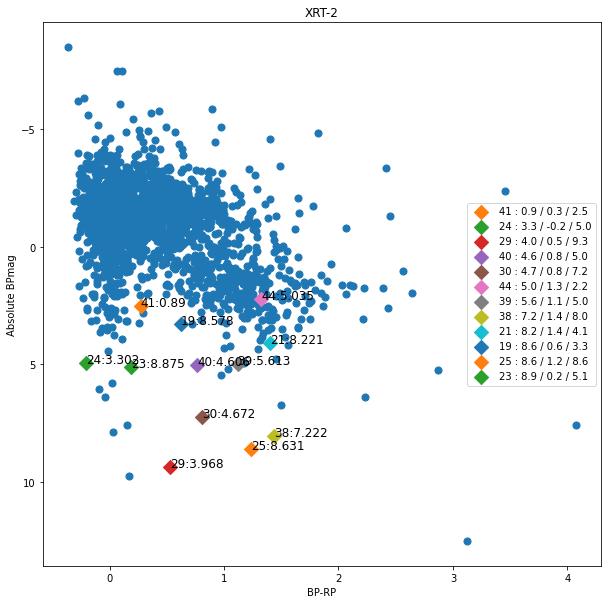

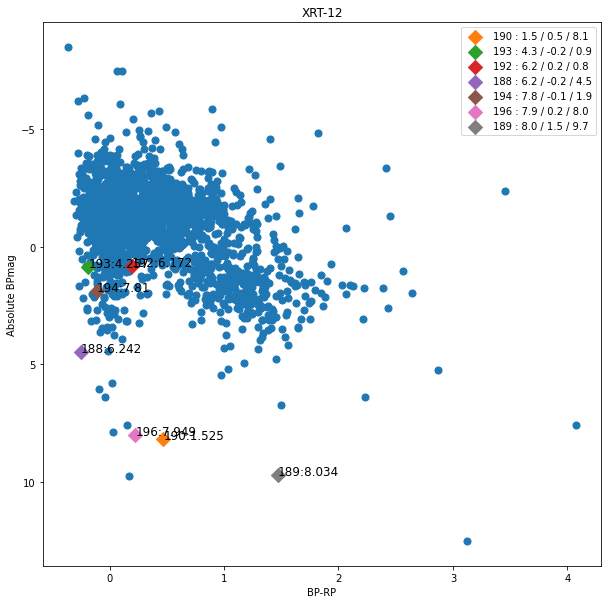

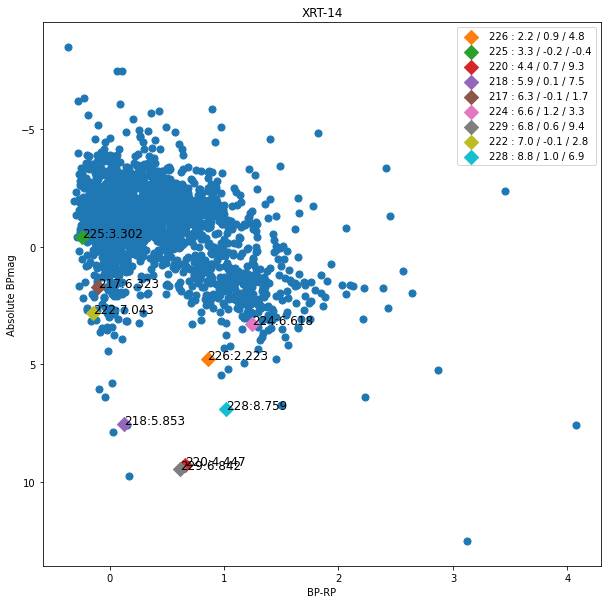

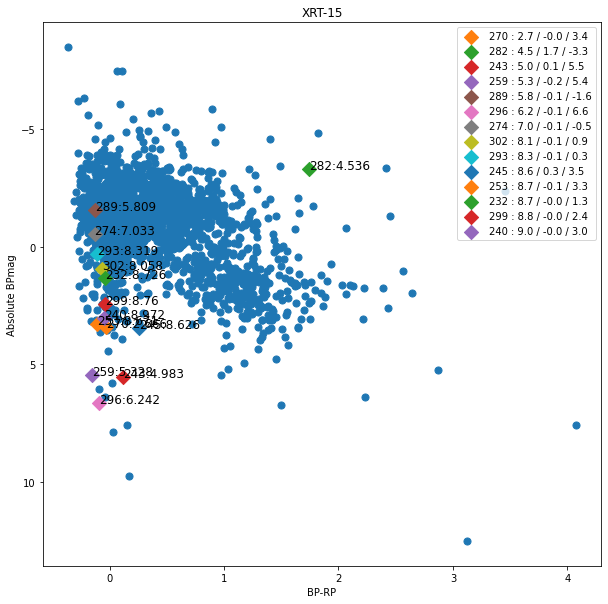

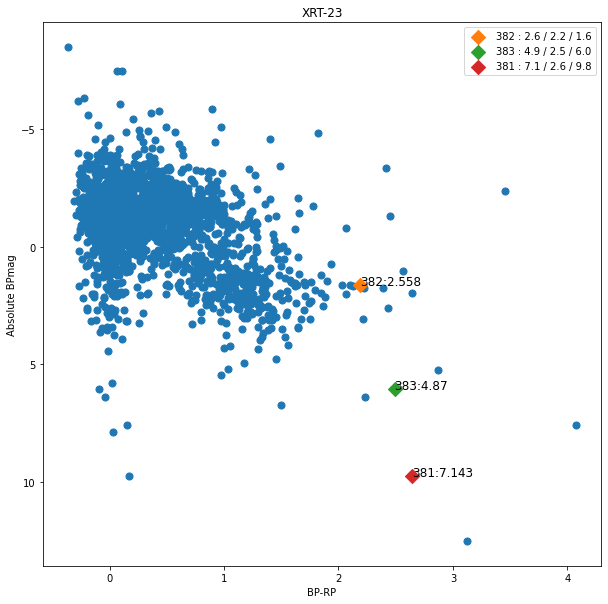

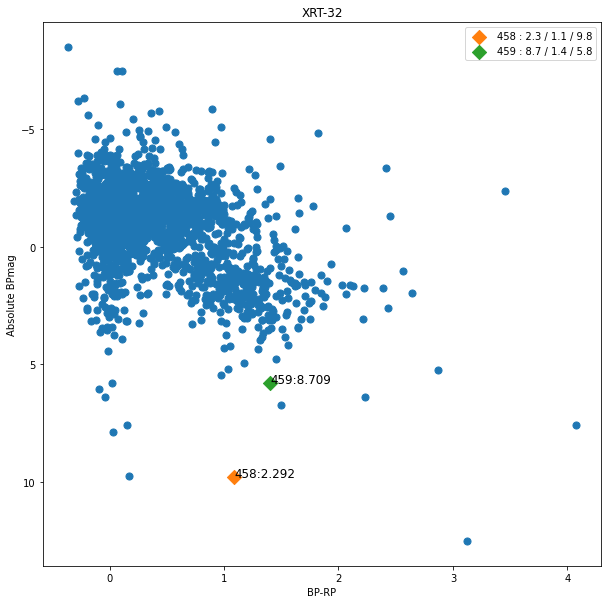

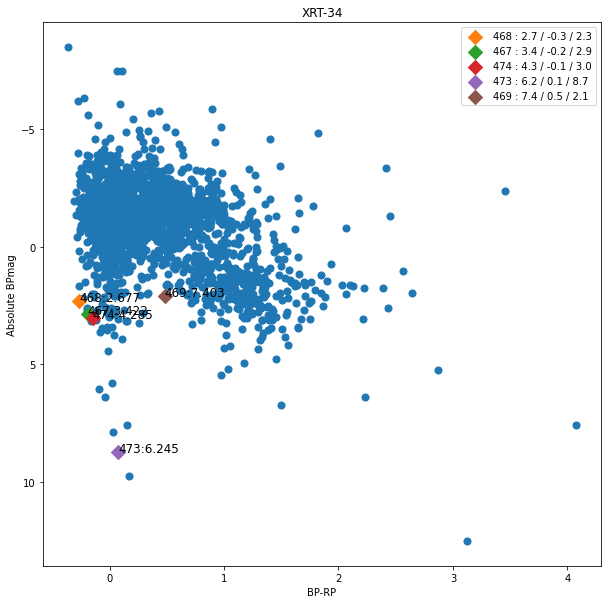

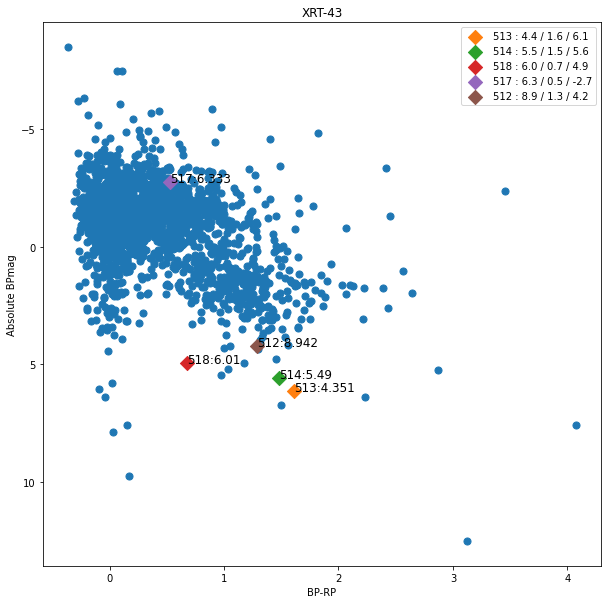

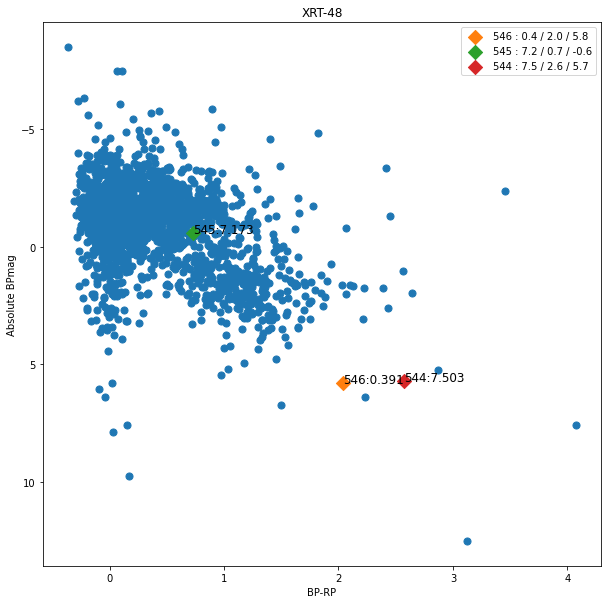

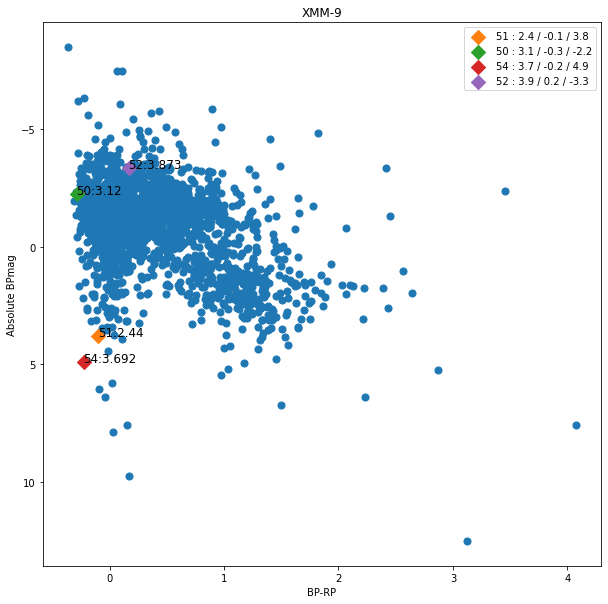

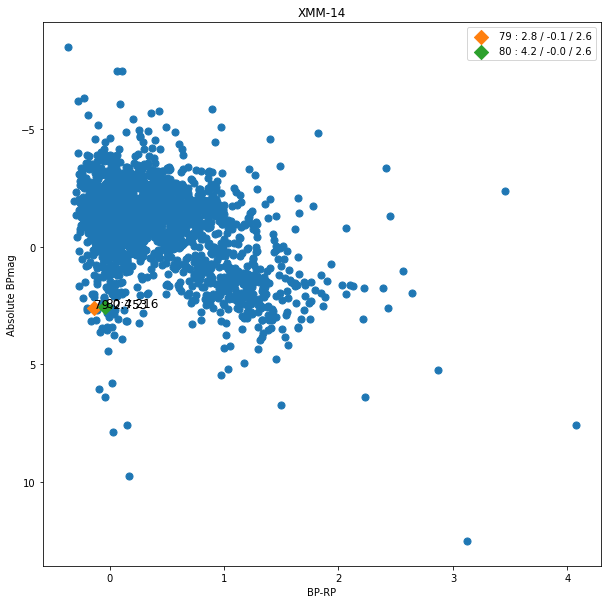

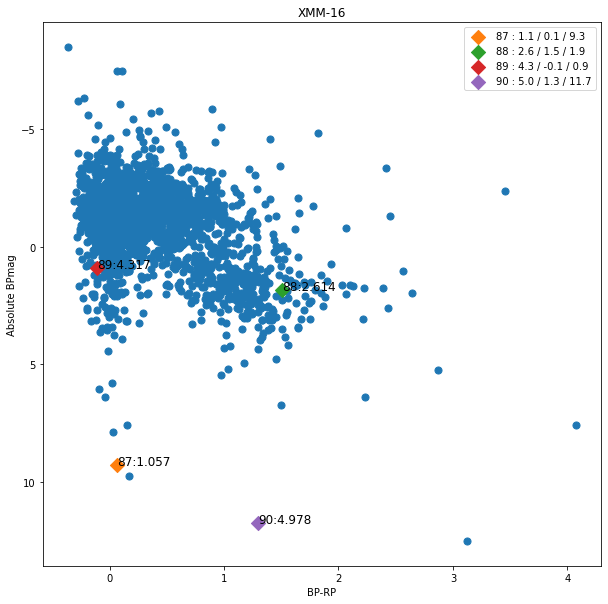

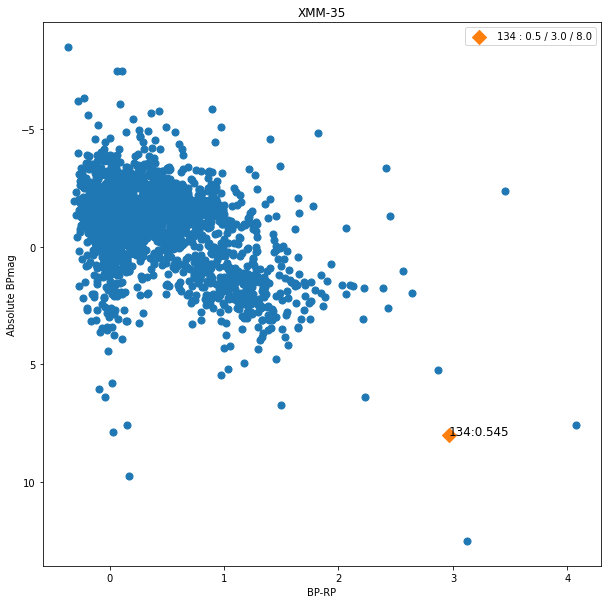

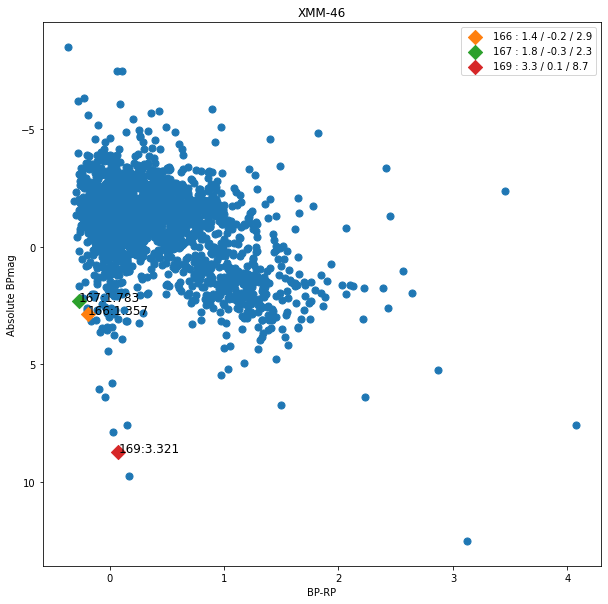

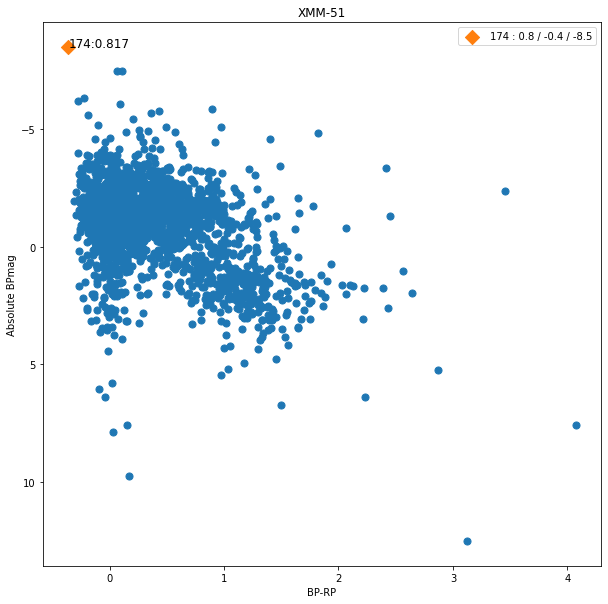

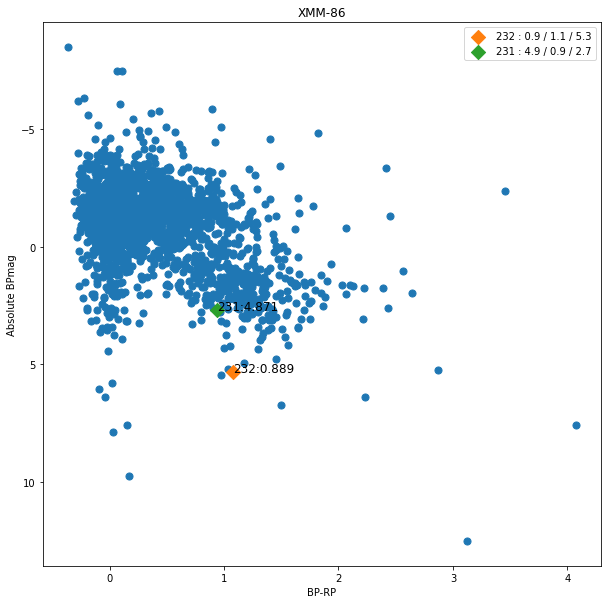

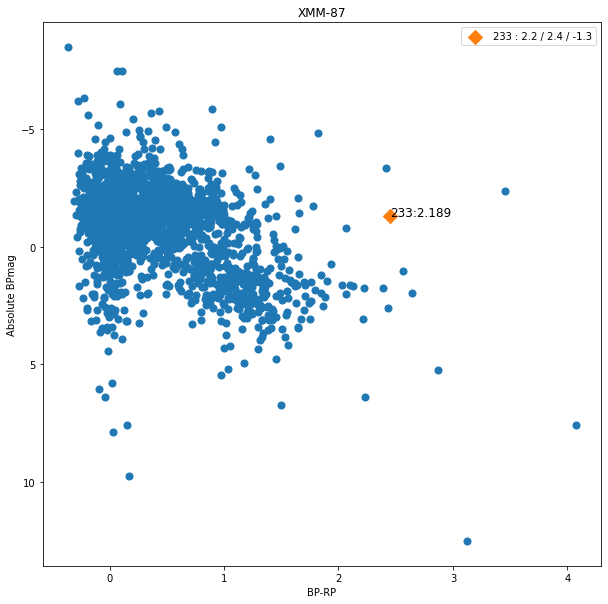

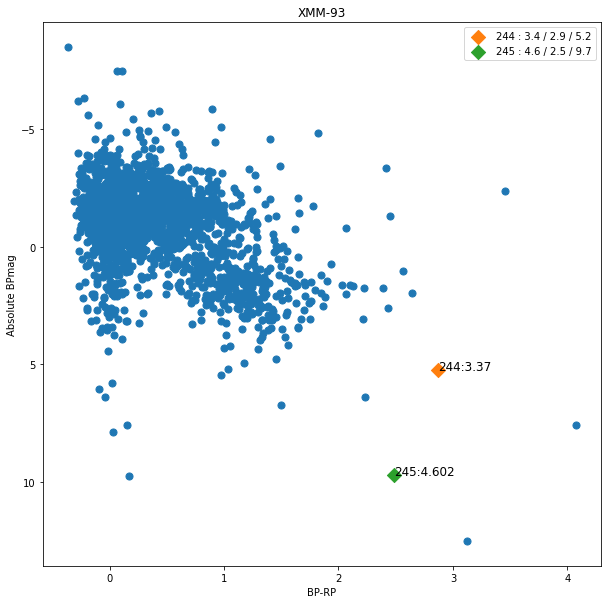

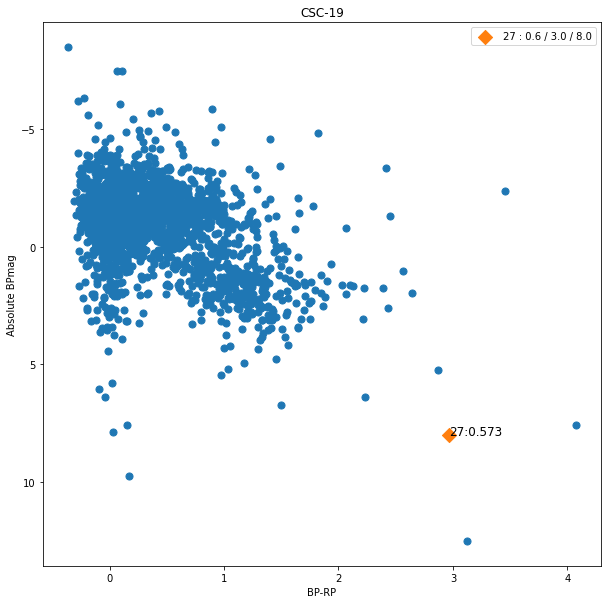

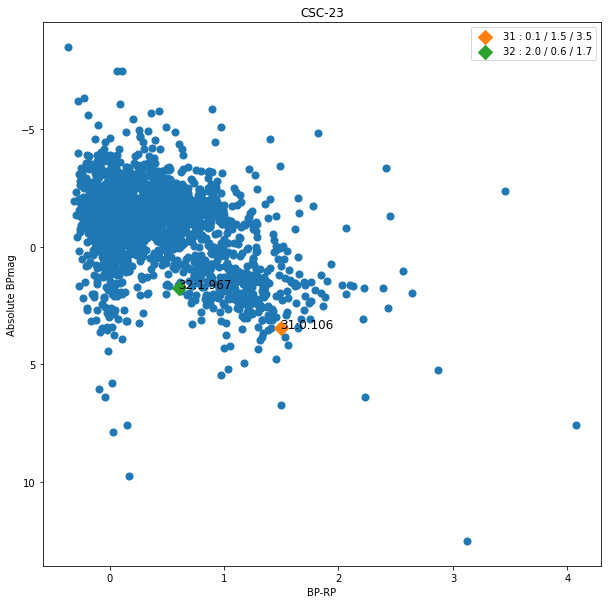

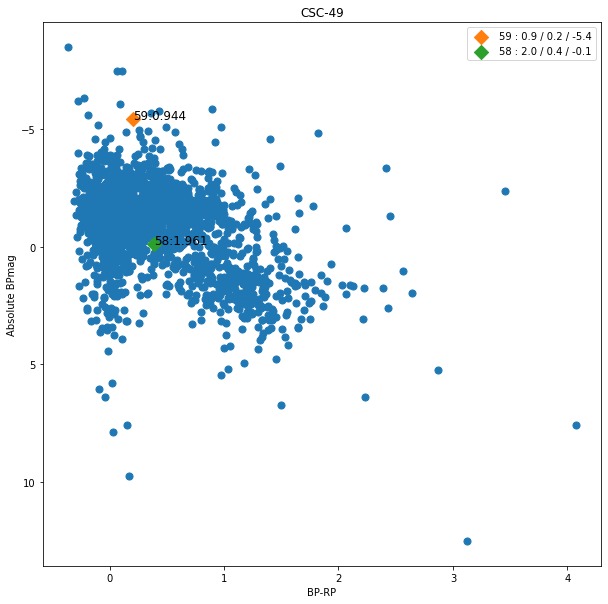

In [72]:
updated = {}

for X_gaia, gaia_X, cat in zip([ XRT_gaia,  XMM_gaia, CSC_gaia] , [df_XRT, df_XMM, df_CSC], [ 'XRT', 'XMM', 'CSC']):

    for i in X_gaia['_q'].unique():
        df_sub = X_gaia.loc[X_gaia['_q']==i].sort_values(by=['_r'])
        instances = len(df_sub)
        if instances == 1:
            pass
        elif instances == 0:
                print('strange')
        else:
            df_src = df_sub.loc[df_sub['_r'] ==min(df_sub['_r'])]
            if len(df_src)>1:
                #pass
                #print(df_src.head(1))
                df_nearest = df_src.head(1)
            else:
                df_nearest = df_src

            #print(df_sub)

            #print(df_gaia.loc[df_gaia['Source'].isin(df_nearest['Source']), :])

            #print(int(df_gaia.loc[df_gaia['_q'] == gaia_X.iloc[df_nearest['_q'].values[0]-1]['_q'], 'Source'].values[0]))
            #print(df_gaia.loc[df_gaia['_q'] == gaia_X.iloc[df_nearest['_q'].values[0]-1]['_q'], :])
            #print(df_BeSS.iloc[gaia_X.iloc[df_nearest['_q'].values[0]-1]['_q']-1, :])    

            df_gaia_sub = df_gaia.loc[df_gaia['_q'] == gaia_X.iloc[int(df_nearest['_q'].values[0]-1)]['_q'], :]

            fig, ax = plt.subplots(figsize=(10,10))

            ax.scatter(df_gaia['BP-RP'], df_gaia['abs_BPmag'], s=50)

            for s,row in df_sub[df_sub["BP-RP"].notna() & df_sub["abs_BPmag"].notna()].iterrows():
                ax.scatter(row['BP-RP'], row['abs_BPmag'], marker='D',s=100, label="%1d : %.1f / %.1f / %.1f" % (s, row['_r_x'], row['BP-RP'], row['abs_BPmag']))# str(j)+':'+str(df_sub.loc[s,'_r_x'])+'/'+str(df_sub.loc[s, 'BP-RP'])+'/'+str(df_sub.loc[s,'abs_BPmag']))
                ax.text(row['BP-RP'], row['abs_BPmag'], str(s)+':'+str(row['_r_x']), fontsize=12)
                #ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'X-O-fluxratio']*0.5, r'$\gamma$ Cas', fontsize=12)

            plt.legend()
            plt.gca().invert_yaxis()
            plt.xlabel('BP-RP')
            plt.ylabel('Absolute BPmag')
            plt.title(cat+'-'+str(int(i)))
            updated[cat+'-'+str(int(i))] = np.nan


# Ignore the below ..

In [ ]:
# CSC
# X SMC X-3: 4688985847741087744, 1.24", 13.023438 -72.434508
# 

# drop 
# Cl* NGC 1893 CUF 3104: crowded

# XMM

# RX J0048.5-7302: 4685949198438263040, 2.11", 12.142170 -73.042030 

In [19]:

xray = pd.merge(df_XMM, df_CSC, on="_q", how="outer")
xray = pd.merge(xray, XRT_sources.to_pandas(), on="_q", how="outer")

In [20]:
xray.columns

Index(['_q', '_r_x', '_4XMM', 'Flux1', 'e_Flux1', 'Flux2', 'e_Flux2', 'Flux3',
       'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5', 'e_Flux5', 'Flux8', 'e_Flux8',
       'Flux9', 'e_Flux9', 'HR1_x', 'e_HR1', 'HR2_x', 'e_HR2', 'HR3', 'e_HR3',
       'HR4', 'e_HR4', '_r_y', '_2CXO', 'Fluxb', 'Fluxh', 'Fluxm', 'Fluxs',
       'Fluxu', 'Fluxw', 'HRhm', 'HRhs', 'HRms', 'GamPL', 'NHPL', '_r',
       '_2SXPS', 'CR0', 'E_CR0', 'e_CR0', 'HR1_y', 'HR2_y', 'CR1', 'e_CR1',
       'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0', 'FPO0',
       'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1'],
      dtype='object')

In [21]:
df_BeSS = BeSS.to_pandas()
print(df_BeSS.columns)
print(df_gaia.columns)
#print(df_BeSS[df_BeSS['index']==1900])
#print(df_gaia[df_gaia['_q']==1900])
df_comb = pd.merge(df_BeSS[['index','name','_RAJ2000', '_DEJ2000','mag','type']], df_gaia.drop(columns=['_r','_RAJ2000', '_DEJ2000']), left_on="index", right_on="_q", how="outer")
#print(df_comb[df_comb['index']==1900])
df_comb = pd.merge(df_comb, df_gaiadist.drop(columns=['_r']),left_on="index", right_on="_q", how="outer")
#print(df_comb[df_comb['index']==1900])
master = pd.merge(df_comb, xray.drop(columns=['_r_x','_r_y','_r']),left_on="index", right_on="_q",  how="outer").drop(columns=['_q_x','_q_y'])
master.rename(columns={"HR1_x":"HR1","HR2_x":"HR2","HR1_y":"SwiftHR1","HR2_y":"SwiftHR2"},inplace=True)
#df_comb = pd.merge(pd.merge(pd.merge(df_BeSS[['index','name','mag','type']], df_gaia.drop(columns=['_r']), left_on="index", right_on="_q", how="outer"), df_gaiadist.drop(columns=['_r']), on="_q", how="outer"), xray.drop(columns=['_r_x','_r_y']), on="_q", how="outer") 
print(master.columns)
print(len(master))

Index(['index', 'name', 'col2', 'ra', 'dec', 'mag', 'type', 'col7', 'col8',
       '_RAJ2000', '_DEJ2000'],
      dtype='object')
Index(['_q', '_r', '_RAJ2000', '_DEJ2000', 'EDR3Name', 'Source', 'Plx', 'pmRA',
       'pmDE', 'epsi', 'sepsi', 'RUWE', 'Gmag', 'BPmag', 'RPmag', 'Tefftemp'],
      dtype='object')
Index(['index', 'name', '_RAJ2000', '_DEJ2000', 'mag', 'type', 'EDR3Name',
       'Source', 'Plx', 'pmRA', 'pmDE', 'epsi', 'sepsi', 'RUWE', 'Gmag',
       'BPmag', 'RPmag', 'Tefftemp', 'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo',
       'b_rpgeo', 'B_rpgeo', 'Flag', '_q', '_4XMM', 'Flux1', 'e_Flux1',
       'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5',
       'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1', 'e_HR1',
       'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4', '_2CXO', 'Fluxb',
       'Fluxh', 'Fluxm', 'Fluxs', 'Fluxu', 'Fluxw', 'HRhm', 'HRhs', 'HRms',
       'GamPL', 'NHPL', '_2SXPS', 'CR0', 'E_CR0', 'e_CR0', 'SwiftHR1',
       'SwiftHR2', 'CR1',

In [154]:
master[master['name']=='RX J0048.5-7302']

,index,name,_RAJ2000,_DEJ2000,mag,type,EDR3Name,Source,Plx,pmRA,...,e_CR2,CR3,E_CR3,e_CR3,PcstS0,FPO0,FPU0,Gam1,E_Gam1,e_Gam1
42,43,RX J0048.5-7302,12.14375,-73.041669,14.84,Be,NaN,<NA>,NaN,NaN,...,-0.000132,0.000648,0.000188,-0.000188,5.790000e-09,9.325000e-14,9.57e-14,0.7183,0.78373,1.0


In [155]:
for i in master[master["_2SXPS"].notna()].index:
    # knowns
    SwiftHR1 = master.loc[i,"SwiftHR1"]
    SwiftHR2 = master.loc[i,"SwiftHR2"]
    SwiftFlux = master.loc[i,"FPO0"]

    # unknowns
    F0,F1,F2 = sympy.symbols("F_s, F_m, F_h")
    
    # equations
    fluxsum = sympy.Eq(F0+F1+F2, SwiftFlux)
    hr1 = sympy.Eq((F1-F0)/(F1+F0), SwiftHR1)
    hr2 = sympy.Eq((F2-F1)/(F2+F1), SwiftHR2)
    
    # solution
    solution = sympy.solve((fluxsum,hr1,hr2), (F0,F1,F2))
    master.loc[i,"XRTsoft"] = float(solution[F0])
    master.loc[i,"XRTmed"] = float(solution[F1])
    master.loc[i,"XRThard"] = float(solution[F2])

In [156]:
def infer_gamma(HR,freq1a,freq1b,freq2a,freq2b):
    #G = sympy.var("Gamma")
    #hr_eq = sympy.Eq(((freq2b**(2-G) - freq2a**(2-G)) - (freq1b**(2-G) - freq1a**(2-G)))/((freq2b**(2-G) - freq2a**(2-G)) + (freq1b**(2-G) - freq1a**(2-G))), HR)
    hr_func = lambda G : -HR + ((freq2b**(2-G) - freq2a**(2-G)) - (freq1b**(2-G) - freq1a**(2-G)))/((freq2b**(2-G) - freq2a**(2-G)) + (freq1b**(2-G) - freq1a**(2-G)))
    solution = optimize.fsolve(hr_func, 1) #sympy.solve(hr_eq, G)
    return solution

In [157]:
CSC_fluxs = ['Fluxs', 'Fluxm', 'Fluxh']
XMM_fluxs = ['Flux1', 'Flux2', 'Flux3', 'Flux4', 'Flux5']
XRT_fluxs = ['XRTsoft', 'XRTmed', 'XRThard']

In [158]:
for i in master[master["_2CXO"].notna() | master["_4XMM"].notna() | master["_2SXPS"].notna()].index:
    cxoflux, xmmflux, xrtflux = master.loc[i,CSC_fluxs].values, master.loc[i,XMM_fluxs].values, master.loc[i,XRT_fluxs].values
    if pd.notna(master.loc[i,"GamPL"]): # spectral index from Chandra
        Gamma = float(master.loc[i,"GamPL"])
    elif pd.notna(master.loc[i,"Gam1"]): # spectral index from Swift
        Gamma = float(master.loc[i,"Gam1"])
    else: # assume flat spectrum for general case
        Gamma = 2
    if all(pd.notna(cxoflux)): # good Chandra observations present
        if Gamma != 2:
            coefs = np.array([(1**(2.-Gamma)-0.3**(2.-Gamma))/(1.2**(2.-Gamma)-0.5**(2.-Gamma)),
                          (2**(2.-Gamma)-1**(2.-Gamma))/(2.**(2.-Gamma)-1.2**(2.-Gamma)),
                          (10**(2.-Gamma)-2**(2.-Gamma))/(7**(2.-Gamma)-2**(2.-Gamma))])
        else:
            coefs = np.array([(np.log(1)-np.log(0.3))/(np.log(1.2)-np.log(0.5)),
                              (np.log(2)-np.log(1))/(np.log(2.0)-np.log(1.2)),
                              (np.log(10)-np.log(2))/(np.log(7)-np.log(2))])
        converted = cxoflux * coefs
        source = "CXO"
    elif all(pd.notna(xmmflux)): # no Chandra, but good XMM
        mergedxmm = np.array([xmmflux[0]+xmmflux[1], xmmflux[2], xmmflux[3]+xmmflux[4]])
        if Gamma != 2:
            coefs = np.array([(1**(2.-Gamma)-0.3**(2.-Gamma))/(1**(2.-Gamma)-0.2**(2.-Gamma)),
                          1, (10**(2.-Gamma)-2**(2.-Gamma))/(12**(2.-Gamma)-2**(2.-Gamma))])
        else:
            coefs = np.array([(np.log(1)-np.log(0.3))/(np.log(1)-np.log(0.2)),
                              1, (np.log(10)-np.log(2))/(np.log(12)-np.log(2))])
        converted = mergedxmm * coefs
        source = "XMM"
    elif all(pd.notna(xrtflux)): # neither Chandra nor XMM, but good Swift-XRT
        converted = xrtflux
        source = "XRT"
    else:
        continue
    
    master.loc[i,"Flux (0.3-1 keV)"] = converted[0]
    master.loc[i,"Flux (1-2 keV)"] = converted[1]
    master.loc[i,"Flux (2-10 keV)"] = converted[2]
    master.loc[i,"Gamma"] = Gamma
    master.loc[i,"X-ray source"] = source

In [159]:
master['dist'] = master['rgeo']
master.loc[master['name'] == 'gam Cas', 'dist'] = 188

In [160]:
master.columns

Index(['index', 'name', '_RAJ2000', '_DEJ2000', 'mag', 'type', 'EDR3Name',
       'Source', 'Plx', 'pmRA', 'pmDE', 'epsi', 'sepsi', 'RUWE', 'Gmag',
       'BPmag', 'RPmag', 'Tefftemp', 'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo',
       'b_rpgeo', 'B_rpgeo', 'Flag', '_q', '_4XMM', 'Flux1', 'e_Flux1',
       'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5',
       'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1', 'e_HR1',
       'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4', '_2CXO', 'Fluxb',
       'Fluxh', 'Fluxm', 'Fluxs', 'Fluxu', 'Fluxw', 'HRhm', 'HRhs', 'HRms',
       'GamPL', 'NHPL', '_2SXPS', 'CR0', 'E_CR0', 'e_CR0', 'SwiftHR1',
       'SwiftHR2', 'CR1', 'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3',
       'e_CR3', 'PcstS0', 'FPO0', 'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1',
       'XRTsoft', 'XRTmed', 'XRThard', 'Flux (0.3-1 keV)', 'Flux (1-2 keV)',
       'Flux (2-10 keV)', 'Gamma', 'X-ray source', 'dist'],
      dtype='object')

In [161]:
master["HR_2-10_0.3-2"] = (master['Flux (2-10 keV)'] - master['Flux (0.3-1 keV)'] - master['Flux (1-2 keV)']) / (master['Flux (2-10 keV)'] + master['Flux (0.3-1 keV)'] + master['Flux (1-2 keV)'])

master["Gflux"] = (2.5e-9*10**(master["Gmag"]/(-2.5))) * 4052.97 

master["Flux (0.3-10 keV)"] = master['Flux (2-10 keV)'] + master['Flux (0.3-1 keV)'] + master['Flux (1-2 keV)']

master['LX'] = master["Flux (0.3-10 keV)"] * 4 * np.pi * (master['dist']* 3.086e+18)**2 

master['X-O-fluxratio'] = master["Flux (0.3-10 keV)"]/ master["Gflux"]

master['BP-RP'] = master["BPmag"] - master["RPmag"]


In [162]:
#print(np.nanmin(master['X-O-fluxratio']))

In [163]:
master_simbad = XMatch.query(cat1=Table.from_pandas(master),
                         cat2='vizier:SIMBAD',max_distance=2 * u.arcsec, colRA1='_RAJ2000',colDec1='_DEJ2000')

#print(master_simbad.columns)
print(len(master_simbad))
master_simbad = find_nearest(master_simbad.to_pandas(), ind_col='index', sep_col='angDist')
print(len(master_simbad))

master = pd.merge(master, master_simbad[['index','main_type','main_id']],on="index",  how="outer")
print(len(master))
print(master.columns)

2302
2159
2264
Index(['index', 'name', '_RAJ2000', '_DEJ2000', 'mag', 'type', 'EDR3Name',
       'Source', 'Plx', 'pmRA', 'pmDE', 'epsi', 'sepsi', 'RUWE', 'Gmag',
       'BPmag', 'RPmag', 'Tefftemp', 'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo',
       'b_rpgeo', 'B_rpgeo', 'Flag', '_q', '_4XMM', 'Flux1', 'e_Flux1',
       'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5',
       'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1', 'e_HR1',
       'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4', '_2CXO', 'Fluxb',
       'Fluxh', 'Fluxm', 'Fluxs', 'Fluxu', 'Fluxw', 'HRhm', 'HRhs', 'HRms',
       'GamPL', 'NHPL', '_2SXPS', 'CR0', 'E_CR0', 'e_CR0', 'SwiftHR1',
       'SwiftHR2', 'CR1', 'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3',
       'e_CR3', 'PcstS0', 'FPO0', 'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1',
       'XRTsoft', 'XRTmed', 'XRThard', 'Flux (0.3-1 keV)', 'Flux (1-2 keV)',
       'Flux (2-10 keV)', 'Gamma', 'X-ray source', 'dist', 'HR_2-10_0.3-2',
       'Gflux', 'Flux 

In [164]:
master_xray = master[~master['Flux (0.3-10 keV)'].isnull()].reset_index(drop=True)

In [165]:
for i in master_xray.index:
    flags = []
    #if pd.notna(master_xray.loc[i,"Be star"]):
        #flags.append("BeSS")
    if pd.notna(master_xray.loc[i,"EDR3Name"]):
        flags.append("Gaia")
#     if pd.notna(master.loc[i,"Name"]):
#         flags.append("HMXB")
    if pd.notna(master_xray.loc[i,"_4XMM"]):
        flags.append("XMM")
    if pd.notna(master_xray.loc[i,"_2CXO"]):
        flags.append("CSC")
    if pd.notna(master_xray.loc[i,"_2SXPS"]):
        flags.append("XRT")
    master_xray.loc[i,"Memberships"] = ",".join(flags)
    


In [166]:
master_xray.loc[master_xray['name']=='CD-29 5159', "Memberships"] = master_xray.loc[master_xray['name']=='CD-29 5159', "Memberships"]+",CSC"
master_xray.loc[master_xray['name']=='EM* MWC 659', "Memberships"] = master_xray.loc[master_xray['name']=='EM* MWC 659', "Memberships"]+",XMM"

#print(master_xray.loc[master_xray['name']=='EM* MWC 659', "Memberships"])

In [167]:
masterXray_table = Table.from_pandas(master_xray)
masterXray_table["_RAJ2000"] = masterXray_table["_RAJ2000"] *u.degree
masterXray_table["_DEJ2000"] = masterXray_table["_DEJ2000"] *u.degree

HMXBs_masterXray = v.query_region(masterXray_table, catalog="J/A+A/455/1165/table1", radius="1s")


for i in range(len(master_xray)):
    if i+1 in (HMXBs_masterXray[0]['_q']):
        #print(masterXray.loc[i, '_RAJ2000'], masterXray.loc[i, 'main_type'])
        master_xray.loc[i,'Class'] = 'HMXB'
    elif master_xray.loc[i,'main_type'] == 'HMXB':
        master_xray.loc[i,'Class'] = 'HMXB'
    elif master_xray.loc[i,'main_type'] == 'YSO':
         master_xray.loc[i,'Class'] = 'YSO'
    else:
        master_xray.loc[i,'Class'] = 'star'

In [168]:
print(Counter(master_xray['Class']))

Counter({'star': 78, 'HMXB': 40, 'YSO': 4})


In [169]:
gamma_cass = pd.read_csv("/Users/yanghui/Desktop/Research/2020/Proposal/XMM/BeSS_Epsilon/GammaCassAnalogs.csv")

gamma_cass_coordinates = SkyCoord(gamma_cass['ra'], gamma_cass['dec'], frame='icrs',unit=(u.hourangle, u.deg))

gamma_cass['_RAJ2000'] = gamma_cass_coordinates.ra.degree
gamma_cass['_DEJ2000'] = gamma_cass_coordinates.dec.degree

for i in range(len(master_xray)):
    c1 = SkyCoord(master_xray.loc[i, '_RAJ2000']* u.degree, master_xray.loc[i, '_DEJ2000']* u.degree, frame='icrs')
    
    sep = c1.separation(gamma_cass_coordinates).arcsec
    if min(sep)<1:
        master_xray.loc[i,'Class'] = r'$\gamma$ Cas analog'


In [170]:
print(Counter(master_xray['Class']))
print(master_xray.loc[master_xray['Class'] == r'$\gamma$ Cas analog', ['main_id']])

Counter({'star': 67, 'HMXB': 38, '$\\gamma$ Cas analog': 13, 'YSO': 4})
         main_id
13     * gam Cas
23     HD  12882
49     HD  45314
61     HD  90563
73     HD 110432
77     HD 119682
78     HD 120991
80     HD 130437
85     HD 157832
87     HD 161103
90     HD 162718
91     HD 316568
113  BD+43  3913


In [227]:
master_xray.loc[master_xray['main_id'] == 'CD-29  5159', 'Class'] = 'HMXB'
master_xray.loc[master_xray['main_id'] == 'EM* MWC  659', 'Class'] = r'$\gamma$ Cas analog'
master_xray.loc[master_xray['main_id'] == '* pi. Aqr', 'Class'] = r'$\gamma$ Cas analog'
master_xray.loc[master_xray['main_id'] == 'HD  42054', 'Class'] = r'$\gamma$ Cas analog'

In [228]:
master_xray.loc[master_xray['main_id'] == 'CD-29  5159', :]

,index,name,_RAJ2000,_DEJ2000,mag,type,EDR3Name,Source,Plx,pmRA,...,Flux (0.3-10 keV),LX,X-O-fluxratio,BP-RP,main_type,main_id,Memberships,Class,ebv,nH
58,1161,CD-29 5159,118.927042,-29.564883,10.71,B0Ve,Gaia EDR3 5597252305589385984,5597252305589386240,0.2854,-2.654,...,5.135000e-12,6.924420e+33,0.004789,0.860106,Em*,CD-29 5159,"Gaia,XRT,CSC",HMXB,0.834118,4.679464


In [229]:
master_xray.columns

Index(['index', 'name', '_RAJ2000', '_DEJ2000', 'mag', 'type', 'EDR3Name',
       'Source', 'Plx', 'pmRA',
       ...
       'Flux (0.3-10 keV)', 'LX', 'X-O-fluxratio', 'BP-RP', 'main_type',
       'main_id', 'Memberships', 'Class', 'ebv', 'nH'],
      dtype='object', length=102)

In [230]:
# extinction & absorption

master_xray['ebv']  = master_xray.apply(lambda row: DustMap.ebv(SkyCoord(row._RAJ2000, row._DEJ2000, unit = 'deg'), dustmap='SFD')*0.86, axis=1)
master_xray['nH']   = master_xray.apply(lambda row: GasMap.nh(SkyCoord(row._RAJ2000, row._DEJ2000, unit = 'deg'), nhmap='LAB').value/1.e21, axis=1)




In [231]:
# HMGB

    
for name, coord in zip(['1FGL J1018.6−5856','4FGL J1405.1−6119','LS I +61 303','LS 2883','HESS J0632+057','LS 5039','TeV J2032+4130'], [['10 19 02.270', '-58 56 29.87'], ['14 05 11.6', '-61 19 56'], ['02 40 31.6641883136', '+61 13 45.591138110'], ['13 02 47.6541729594','-63 50 08.62592286'], ['06 32 59.2566624297','+05 48 01.162565528'], ['18 26 15.0561532140', '-14 50 54.249464136'], ['20 32 06.0', '+41 34 00']]):
    #print(name, coord)
    HMGB_coordinates = SkyCoord(coord[0], coord[1], frame='icrs',unit=(u.hourangle, u.deg))
    #print(name, HMGB_coordinates)
    master_xray_coordinates = SkyCoord(master_xray['_RAJ2000'], master_xray['_DEJ2000'], frame='icrs',unit=(u.deg, u.deg))

    sep = HMGB_coordinates.separation(master_xray_coordinates).arcsec
    if min(sep)<1:
        print(name, HMGB_coordinates,min(sep))
        ind = np.where(sep == min(sep))[0]
        print(sep[ind])
        
        master_xray.loc[ind,'Class'] = 'HMGB'
        master_xray.loc[ind,'main_id'] = name


LS I +61 303 <SkyCoord (ICRS): (ra, dec) in deg
    (40.13193412, 61.22933087)> 0.0460025711428203
[0.04600257]
LS 2883 <SkyCoord (ICRS): (ra, dec) in deg
    (195.69855905, -63.83572942)> 0.05855096730404991
[0.05855097]
HESS J0632+057 <SkyCoord (ICRS): (ra, dec) in deg
    (98.24690276, 5.80032293)> 0.10094180778639088
[0.10094181]


In [232]:
print(Counter(master_xray['Class']))

print(master_xray.loc[master_xray['main_id']== '* gam Cas', :])

Counter({'star': 63, 'HMXB': 36, '$\\gamma$ Cas analog': 16, 'YSO': 4, 'HMGB': 3})
   index     name   _RAJ2000   _DEJ2000   mag    type  \
13   217  gam Cas  14.177208  60.716742  2.47  B0IVpe   

                        EDR3Name              Source  Plx  pmRA  ...  \
13  Gaia EDR3 426558460884582016  426558460884582016  NaN   NaN  ...   

    Flux (0.3-10 keV)            LX  X-O-fluxratio     BP-RP  main_type  \
13       1.949466e-10  8.245807e+32       0.000129  0.410734        Be*   

      main_id  Memberships                Class       ebv        nH  
13  * gam Cas     Gaia,XMM  $\gamma$ Cas analog  0.673598  4.155273  

[1 rows x 102 columns]


"\nfor area, eps in zip([100, 200, 400, 600, 1000], [0, 0.4, 1.2, 2.0, 3.6]):\n    plt.scatter([], [], c='k', alpha=0.3, s=area,\n                label=r'$\\epsilon$=' + str(eps) )\nplt.legend(scatterpoints=1, frameon=False, labelspacing=1)\n\n\n\n\n\n\n\n\n\n\n\nplt.xlabel(r'HR=$\x0crac{F_{2-7} - F_{0.5-2}}{F_{2-7} + F_{0.5-2}}$', fontsize=30)\nplt.ylabel(r'L$_{X}$(erg s$^{-1}$)', fontsize=30)\nplt.yticks(fontsize=25)\nplt.xticks(fontsize=25)\n"

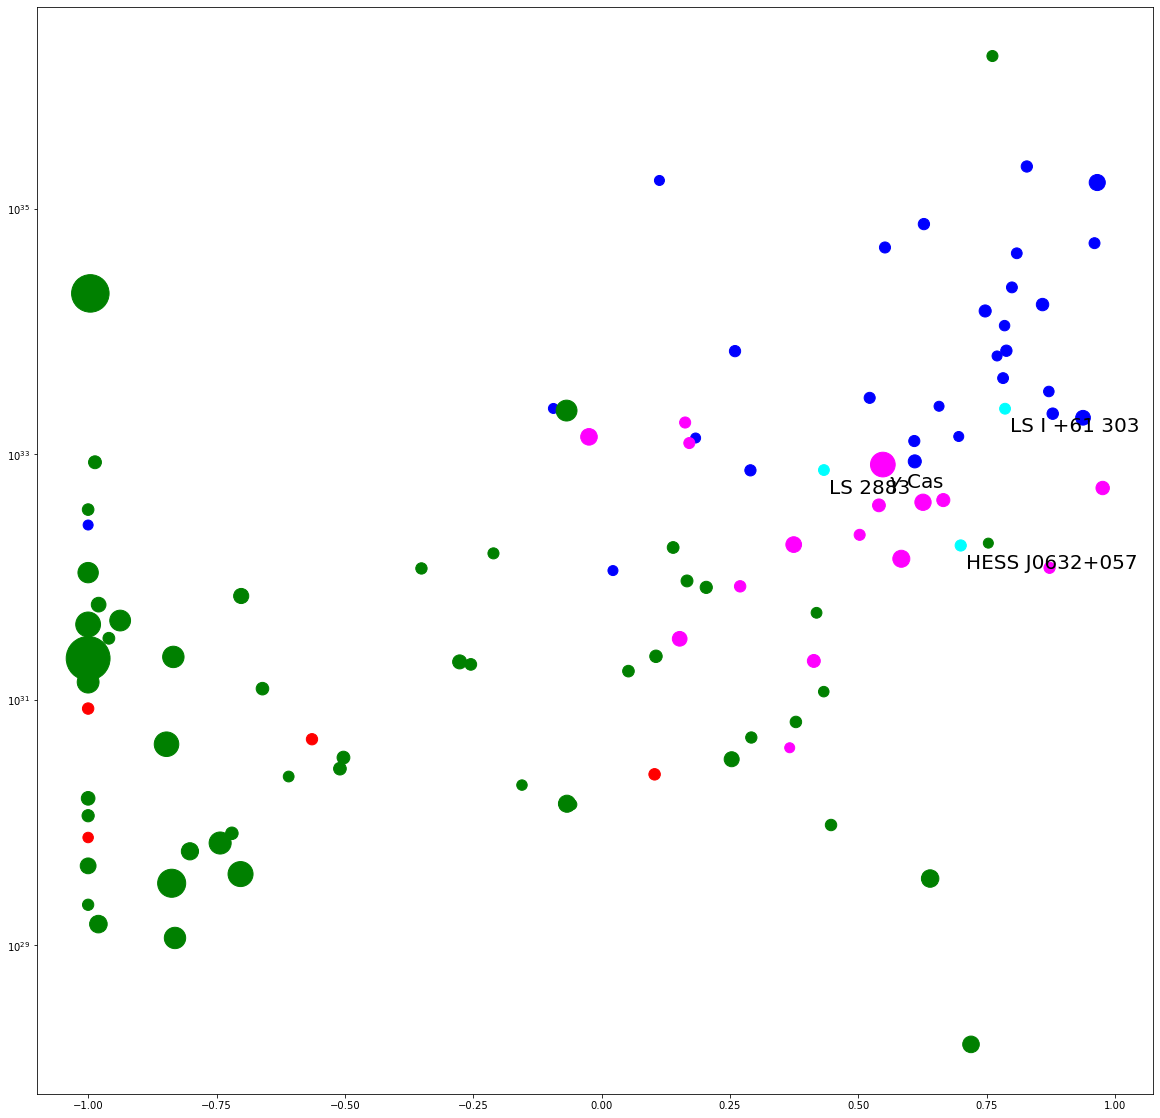

In [233]:
fig, ax = plt.subplots(figsize=(20,20))

master_xray = master_xray.reset_index(drop=True)

for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_2-10_0.3-2']+0.01, master_xray.loc[i,'LX']*0.65, master_xray.loc[i,'main_id'], fontsize=20)
    if (master_xray.loc[i, 'name'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_2-10_0.3-2']+0.01, master_xray.loc[i,'LX']*0.65, r'$\gamma$ Cas', fontsize=20)


for clas, color in zip(['HMXB','YSO','star','HMGB', '$\\gamma$ Cas analog'], ['blue', 'red', 'green', 'cyan', 'magenta']):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)


ax.set_yscale('log')

#ax.legend()

'''
for area, eps in zip([100, 200, 400, 600, 1000], [0, 0.4, 1.2, 2.0, 3.6]):
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=r'$\epsilon$=' + str(eps) )
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)











plt.xlabel(r'HR=$\frac{F_{2-7} - F_{0.5-2}}{F_{2-7} + F_{0.5-2}}$', fontsize=30)
plt.ylabel(r'L$_{X}$(erg s$^{-1}$)', fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
'''
#plt.show()
#plt.savefig("HR_LX.png")




In [234]:
print(Counter(master_xray['Memberships']))


print(Counter(master_xray.loc[master_xray['Memberships'].str.contains('XMM|CSC'), 'Memberships']))

print(master_xray.loc[~master_xray['Memberships'].str.contains('Gaia'), ['LX']])

Counter({'Gaia,XMM': 31, 'Gaia,CSC': 23, 'Gaia,XRT': 14, 'Gaia,XMM,CSC': 13, 'Gaia,XMM,CSC,XRT': 11, 'XRT': 7, 'Gaia,CSC,XRT': 7, 'Gaia,XMM,XRT': 6, 'XMM,XRT': 4, 'XMM': 3, 'XMM,CSC,XRT': 1, 'Gaia,XRT,CSC': 1, 'Gaia,XRT,XMM': 1})
Counter({'Gaia,XMM': 31, 'Gaia,CSC': 23, 'Gaia,XMM,CSC': 13, 'Gaia,XMM,CSC,XRT': 11, 'Gaia,CSC,XRT': 7, 'Gaia,XMM,XRT': 6, 'XMM,XRT': 4, 'XMM': 3, 'XMM,CSC,XRT': 1, 'Gaia,XRT,CSC': 1, 'Gaia,XRT,XMM': 1})
    LX
0  NaN
1  NaN
6  NaN
12 NaN
15 NaN
16 NaN
17 NaN
21 NaN
27 NaN
36 NaN
37 NaN
39 NaN
40 NaN
79 NaN
97 NaN


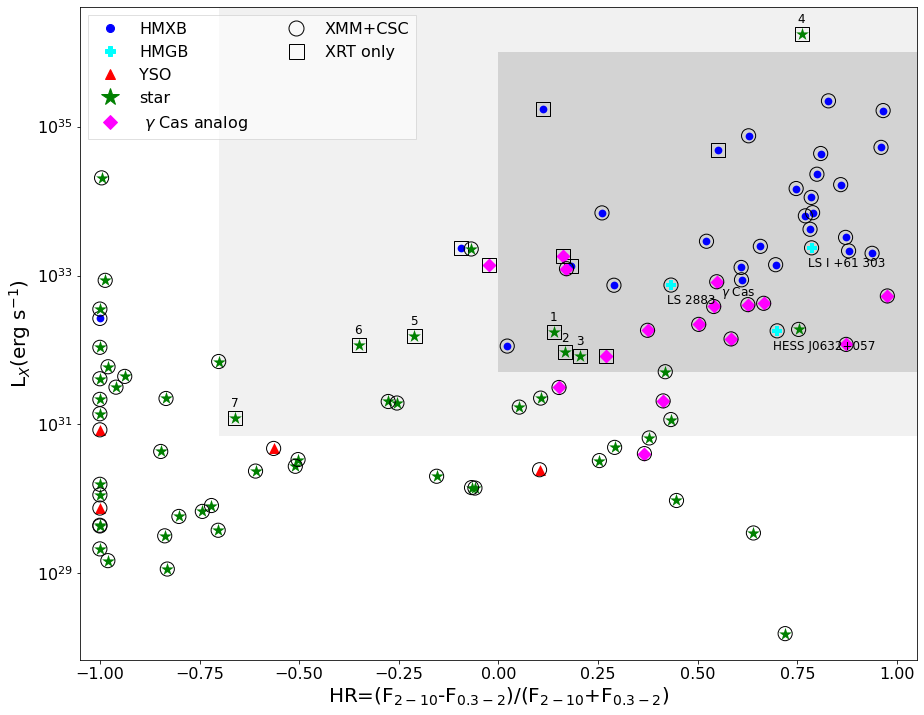

In [296]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

ax.add_patch(mpl.patches.Rectangle((0,5e31),2.2,1e36, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=1))

ax.add_patch(mpl.patches.Rectangle((-0.7,7e30),2.2,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.3))


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    #scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX",  marker='o', linewidth=1, facecolors='none', edgecolors='k', s=200, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
#for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [100, 120, 120, 100, 180]):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    #scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)
    #sns.scatterplot(data=master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker='P', s=120, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker=marker, s=size, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX",  marker='o', linewidth=1, facecolors='none', edgecolors='k', s=200, ax=ax, legend=True)
    
    #ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="b")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_2-10_0.3-2']-0.01, master_xray.loc[i,'LX']*0.55, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_2-10_0.3-2']+0.01, master_xray.loc[i,'LX']*0.65, r'$\gamma$ Cas', fontsize=12)

for i, src in zip(range(1,8), ['HD 298369', 'HD 248753', 'HD 237056', 'HD 305560', 'HD 228256', 'HD 166188', 'HD  19818']):
    #print(i, master_xray[master_xray['main_id']==src]['HR_2-10_0.3-2']-0.01)
    ax.text(master_xray.loc[master_xray['main_id']==src,'HR_2-10_0.3-2']-0.01, master_xray.loc[master_xray['main_id']==src,'LX']*1.4, str(i), fontsize=12)
    #print(i)
    
    
'''
ax.scatter(total[total["Class"]=="Variable"]["rest"], total[total["Class"]=="Variable"]["epsi"], s=[130 if total[total["Class"]=="Variable"]["Catalog membership"][i]=="Gaia only" else 220 for i in total[total["Class"]=="Variable"].index], linewidth=2, facecolors='none', edgecolors="b", label="Variable")
ax.scatter(total[total["Class"]=="HMXB"]["rest"], total[total["Class"]=="HMXB"]["epsi"], s=[130 if total[total["Class"]=="HMXB"]["Catalog membership"][i]=="Gaia only" else 220 for i in total[total["Class"]=="HMXB"].index], linewidth=2, facecolors='none', edgecolors="g", label="HMXB")
ax.scatter(total[total["Class"]=="YSO"]["rest"], total[total["Class"]=="YSO"]["epsi"], s=[130 if total[total["Class"]=="YSO"]["Catalog membership"][i]=="Gaia only" else 220 for i in total[total["Class"]=="YSO"].index], linewidth=2, facecolors='none', edgecolors="cyan", label="YSO")

ax.set(ylim=(3e-2,10), xlim=(45,45000), xscale="log", yscale="log", xlabel="Distance [pc]", ylabel="Excess astrometric noise ($\epsilon$) [mas]")

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=total["N_H"].min()/1e21, vmax=total["N_H"].max()/1e21, clip=False), cmap='inferno_r'),label='N$_\mathrm{H}$ (×$10^{21}$) [cm$^{-2}$]',ax=ax)
'''
ax.set(ylim=(7e27,4e36), xlim=(-1.05,1.05),  yscale="log", xlabel=r'HR=(F$_{2-10}$-F$_{0.3-2}$)/(F$_{2-10}$+F$_{0.3-2}$)', ylabel=r"L$_X$(erg s$^{-1}$)")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements1 = [
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   ]

legend_elements2 = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                   ]
               
                   


legend = ax.legend(handles=legend_elements1+legend_elements2, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))
#legend = ax.legend(handles=legend_elements2, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))


fig.savefig("LX_vs_HR_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

In [236]:
#master_xray.loc[master_xray['main_id'] == 'CD-29  5159', :]

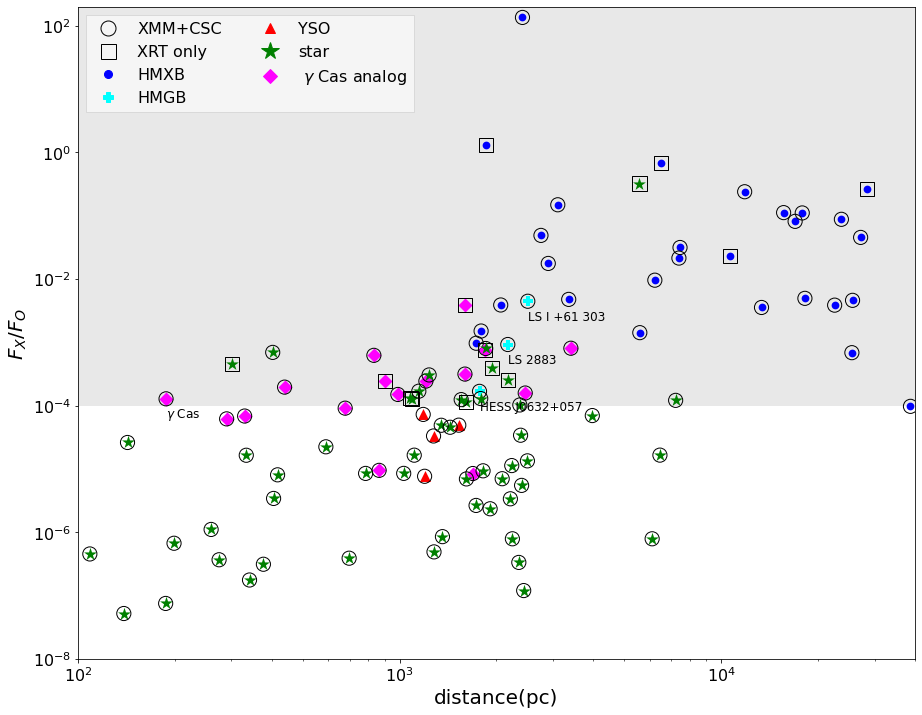

In [274]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

ax.add_patch(mpl.patches.Rectangle((0,1e-4),1e5,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.5))

#ax.add_patch(mpl.patches.Rectangle((-0.7,7e30),2,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.3))


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    #scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="dist", y="X-O-fluxratio", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX",  marker='o', linewidth=1, facecolors='none', edgecolors='k', s=200, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["dist"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["dist"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
#for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [100, 120, 120, 100, 180]):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    #scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)
    #sns.scatterplot(data=master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker='P', s=120, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker=marker, s=size, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX",  marker='o', linewidth=1, facecolors='none', edgecolors='k', s=200, ax=ax, legend=True)
    
    #ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="b")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'X-O-fluxratio']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'X-O-fluxratio']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(100,40000), xscale="log", yscale="log", xlabel='distance(pc)', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

fig.savefig("fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

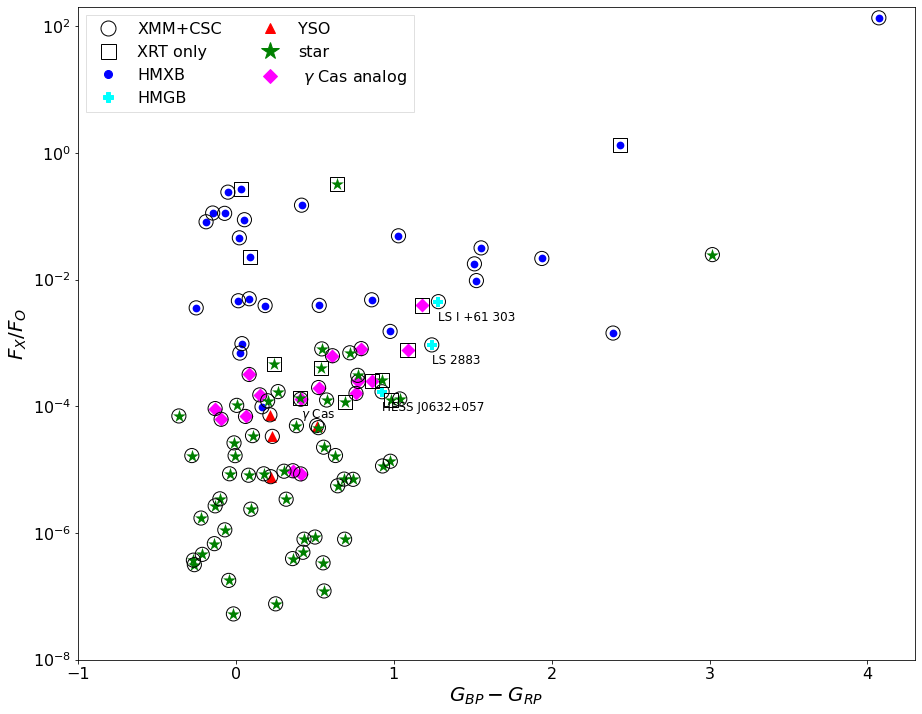

In [275]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

#ax.add_patch(mpl.patches.Rectangle((0,1e-4),1e5,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.5))

#ax.add_patch(mpl.patches.Rectangle((-0.7,7e30),2,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.3))


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    #scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="BP-RP", y="X-O-fluxratio", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX",  marker='o', linewidth=1, facecolors='none', edgecolors='k', s=200, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["BP-RP"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["BP-RP"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
#for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [100, 120, 120, 100, 180]):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    #scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)
    #sns.scatterplot(data=master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker='P', s=120, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker=marker, s=size, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX",  marker='o', linewidth=1, facecolors='none', edgecolors='k', s=200, ax=ax, legend=True)
    
    #ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="b")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'BP-RP'], master_xray.loc[i,'X-O-fluxratio']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'BP-RP'], master_xray.loc[i,'X-O-fluxratio']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(-1,4.3), yscale="log", xlabel=r'$G_{BP}-G_{RP}$', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

#fig.savefig("fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

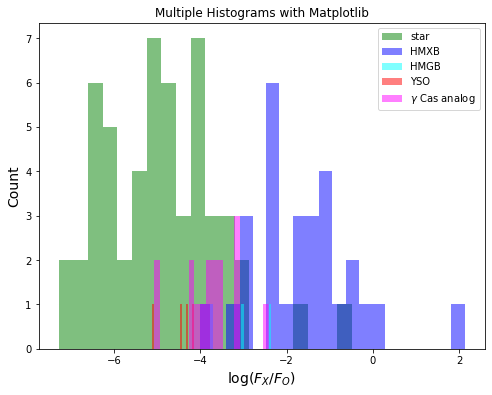

In [272]:
plt.figure(figsize=(8,6))

for clas, color in zip(['star','HMXB','HMGB','YSO','$\\gamma$ Cas analog', ], ['green','blue','cyan', 'red',  'magenta']):
    plt.hist(np.log10(master_xray.loc[(master_xray['Class']==clas) & (master_xray['X-O-fluxratio']>0),'X-O-fluxratio']), bins=20, alpha=0.5, color=color,label=clas)
    #plt.hist(np.log10(master_xray.loc[(master_xray['Class']=='$\\gamma$ Cas analog') & (master_xray['X-O-fluxratio']>0),'X-O-fluxratio']), bins=20, alpha=0.5, label="data1")
    #plt.hist(np.log10(master_xray.loc[(master_xray['Class']=='YSO') & (master_xray['X-O-fluxratio']>0),'X-O-fluxratio']), bins=20, alpha=0.5, color='r',label="data1")

#plt.hist(data2, bins=100, alpha=0.5, label="data2")

plt.xlabel("log($F_X/F_O$)", size=14)
plt.ylabel("Count", size=14)
plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')

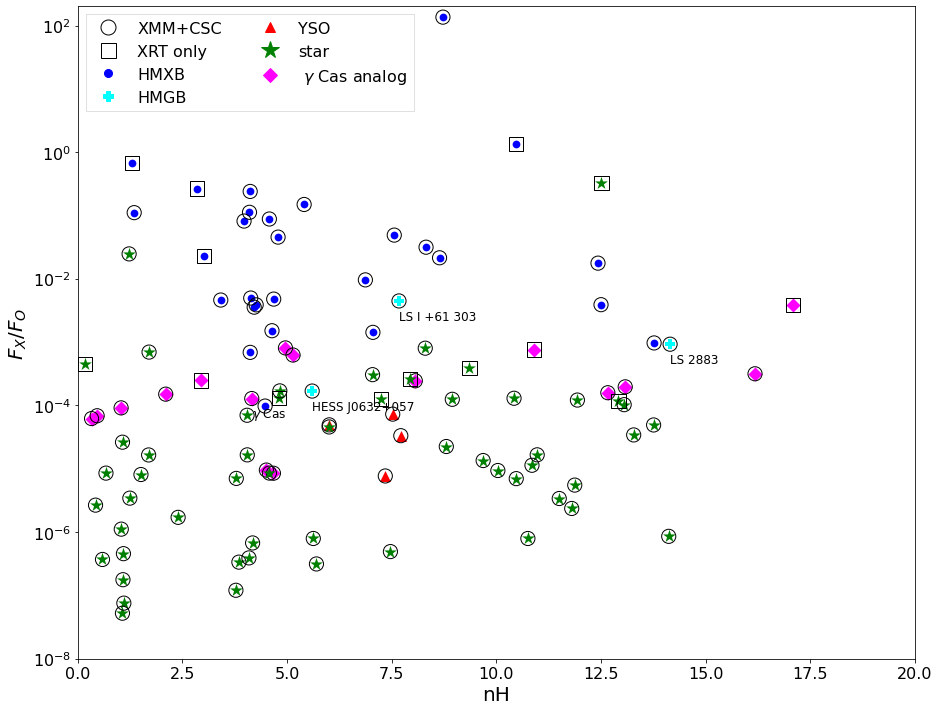

In [276]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

#ax.add_patch(mpl.patches.Rectangle((0,1e-4),1e5,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.5))

#ax.add_patch(mpl.patches.Rectangle((-0.7,7e30),2,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.3))


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    #scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="nH", y="X-O-fluxratio", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX",  marker='o', linewidth=1, facecolors='none', edgecolors='k', s=200, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["nH"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["nH"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
#for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [100, 120, 120, 100, 180]):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    #scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)
    #sns.scatterplot(data=master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker='P', s=120, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker=marker, s=size, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX",  marker='o', linewidth=1, facecolors='none', edgecolors='k', s=200, ax=ax, legend=True)
    
    #ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="b")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'nH'], master_xray.loc[i,'X-O-fluxratio']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'nH'], master_xray.loc[i,'X-O-fluxratio']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(0,20), yscale="log", xlabel='nH', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

#fig.savefig("fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

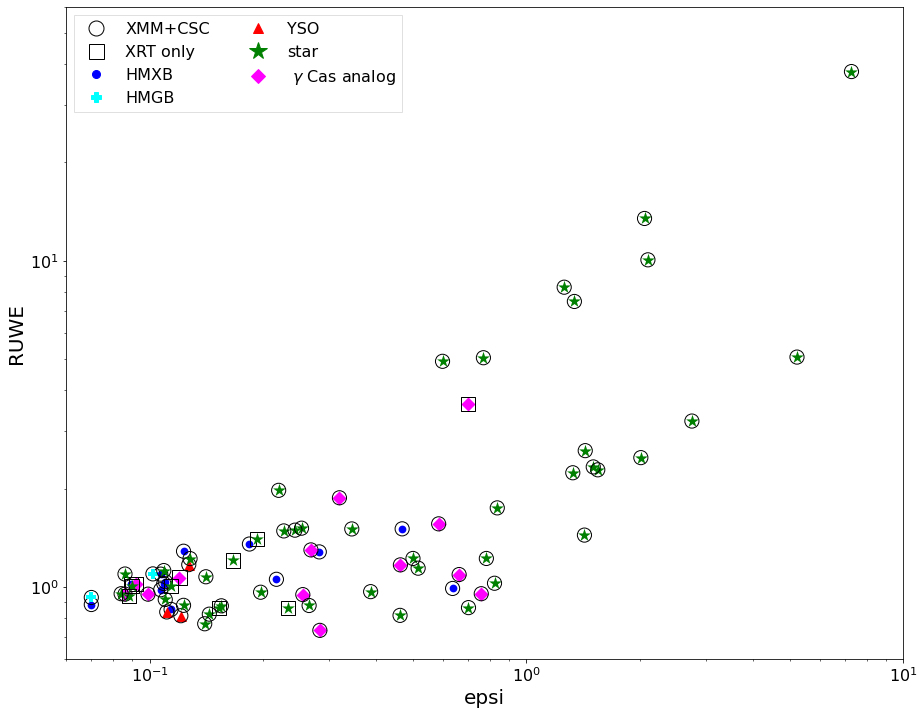

In [277]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

#ax.add_patch(mpl.patches.Rectangle((0,1e-4),1e5,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.5))

#ax.add_patch(mpl.patches.Rectangle((-0.7,7e30),2,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.3))


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    #scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas) & (master_xray['sepsi']>5)], x="epsi", y="RUWE", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX",  marker='o', linewidth=1, facecolors='none', edgecolors='k', s=200, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["epsi"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["RUWE"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["epsi"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["RUWE"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
#for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [100, 120, 120, 100, 180]):
    #print(master_xray.loc[master_xray.Class==clas,'epsi'])
    #scatter = ax.scatter(master_xray.loc[master_xray.Class==clas,'HR_2-10_0.3-2'], master_xray.loc[master_xray.Class==clas,'LX'], s=((master_xray.loc[master_xray.Class==clas,'epsi']/2.)+0.2)*500, c=color, label=clas)
    #sns.scatterplot(data=master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker='P', s=120, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker=marker, s=size, ax=ax, legend=True)
    #sns.scatterplot(data=master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX",  marker='o', linewidth=1, facecolors='none', edgecolors='k', s=200, ax=ax, legend=True)
    
    #ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="b")

'''
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'epsi'], master_xray.loc[i,'RUWE'], master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'epsi'], master_xray.loc[i,'RUWE'], r'$\gamma$ Cas', fontsize=12)
''' 

    
ax.set(xlim=(6e-2,10), ylim=(6e-1,60),  xscale="log", yscale="log", xlabel='epsi', ylabel="RUWE")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))


#fig.savefig("fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

In [241]:
print(master_xray.loc[master_xray['Class']=='HMGB', ['main_id','X-ray source','Fluxh', 'Fluxm', 'Fluxs','Flux (0.3-1 keV)','Flux (1-2 keV)','Flux (2-10 keV)','HR_2-10_0.3-2','Gamma']])

           main_id X-ray source         Fluxh         Fluxm         Fluxs  \
28    LS I +61 303          CXO  1.986877e-12  2.107412e-13  5.174559e-14   
52  HESS J0632+057          XMM           NaN           NaN           NaN   
75         LS 2883          CXO  7.082495e-13  1.844671e-13  1.001692e-13   

    Flux (0.3-1 keV)  Flux (1-2 keV)  Flux (2-10 keV)  HR_2-10_0.3-2   Gamma  
28      6.102091e-14    2.747224e-13     2.796266e-12       0.785605  1.5390  
52      1.337767e-14    5.889130e-14     4.084010e-13       0.699299  1.4470  
75      1.284531e-13    2.457621e-13     9.454995e-13       0.432885  1.7948  


In [242]:
master_xray[master_xray['name'] == 'gam Cas']

,index,name,_RAJ2000,_DEJ2000,mag,type,EDR3Name,Source,Plx,pmRA,...,Flux (0.3-10 keV),LX,X-O-fluxratio,BP-RP,main_type,main_id,Memberships,Class,ebv,nH
13,217,gam Cas,14.177208,60.716742,2.47,B0IVpe,Gaia EDR3 426558460884582016,426558460884582016,NaN,NaN,...,1.949466e-10,8.245807e+32,0.000129,0.410734,Be*,* gam Cas,"Gaia,XMM",$\gamma$ Cas analog,0.673598,4.155273


In [243]:
print(master_xray.loc[(~master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['HR_2-10_0.3-2']>0) & (master_xray['LX']>5e31), ['main_id','Class','X-ray source','LX','HR_2-10_0.3-2','Flux (0.3-10 keV)','_RAJ2000','_DEJ2000','epsi', 'sepsi', 'RUWE','Gmag','BPmag', 'RPmag']])

             main_id                Class X-ray source            LX  \
8            LIN 221                 HMXB          XRT  1.701674e+35   
29         HD 237056                 star          XRT  8.236246e+31   
44   RX J0535.6-6651                 HMXB          XRT  1.357216e+33   
47         HD 248753                 star          XRT  9.293350e+31   
60         HD 298369                 star          XRT  1.740368e+32   
64         HD 305560                 star          XRT  1.756726e+36   
74       V* V850 Cen                 HMXB          XRT  4.840329e+34   
80         HD 130437  $\gamma$ Cas analog          XRT  1.814894e+33   
113      BD+43  3913  $\gamma$ Cas analog          XRT  8.399379e+31   

     HR_2-10_0.3-2  Flux (0.3-10 keV)    _RAJ2000   _DEJ2000   epsi  \
8         0.112569       1.762000e-12   13.230000 -71.968300  0.000   
29        0.203743       5.735000e-13   45.657833  57.612794  0.193   
44        0.182992       2.689000e-13   83.921583 -66.864561  0.00

In [244]:
print(master_xray.loc[(~master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['LX']>7e30) & (master_xray['HR_2-10_0.3-2']>-0.7) & (master_xray['HR_2-10_0.3-2']<0), ['main_id','Class','X-ray source','LX','HR_2-10_0.3-2','Flux (0.3-10 keV)','_RAJ2000','_DEJ2000','epsi', 'sepsi', 'RUWE','Gmag','BPmag', 'RPmag']])

             main_id                Class X-ray source            LX  \
30         HD  19818                 star          XRT  1.231808e+31   
46   RX J0544.1-7100                 HMXB          XRT  2.362567e+33   
90         HD 162718  $\gamma$ Cas analog          XRT  1.386956e+33   
101        HD 166188                 star          XRT  1.174799e+32   
106        HD 228256                 star          XRT  1.558609e+32   

     HR_2-10_0.3-2  Flux (0.3-10 keV)    _RAJ2000   _DEJ2000   epsi  \
30       -0.660501       1.138000e-12   47.108667 -59.373717  0.233   
46       -0.093907       1.745000e-13   86.021583 -71.014061  0.000   
90       -0.024627       3.395000e-12  268.368500 -24.774364  0.699   
101      -0.350908       3.805000e-13  272.576333 -18.194808  0.114   
106      -0.210649       2.744000e-13  302.976542  40.008231  0.090   

          sepsi   RUWE       Gmag      BPmag      RPmag  
30    59.799999  0.861   9.026817   9.097452   8.857716  
46     0.000000  0.932  

In [245]:
master_xray.to_csv('master_xray.csv',index=False)